In [1]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(cowplot)
  library(gridExtra)
  library(data.table)
})

cres_w_grnas = fread("cres_with_grnas.txt")
cres_w_grnas$target_gene = paste0(cres_w_grnas$grna_target,"_",cres_w_grnas$ensembl_id)
cres_w_grnas_egene = fread("cres_with_grna_eqtls.txt")
cres_w_grnas_egene$target_gene = paste0(cres_w_grnas_egene$grna_target,"_",cres_w_grnas_egene$ensembl_id)

In [2]:
total_cres = unique(cres_w_grnas$grna_target)
cat("Total cres tested =",length(total_cres),"\n")

grna_cres_w_cgenes = unique(cres_w_grnas$grna_target[cres_w_grnas$significant == 1])
cat("Total number CREs with cgenes =",length(grna_cres_w_cgenes),"\n")

target_cgenes = unique(cres_w_grnas$target_gene[cres_w_grnas$significant == 1])
cat("Total number of target-cgene pairs =",length(target_cgenes),"\n")

cgenes = unique(cres_w_grnas$ensembl_id[cres_w_grnas$significant == 1])
cat("Total number of cgenes =",length(cgenes),"\n")

grna_cres_w_egenes = unique(cres_w_grnas_egene$grna_target)
cat("Total number CREs with egenes =",length(grna_cres_w_egenes),"\n")

length(unique(c(grna_cres_w_cgenes,grna_cres_w_egenes)))

target_egenes = unique(cres_w_grnas_egene$target_gene)
cat("Total number of target-egene pairs =",length(target_egenes),"\n")

egenes = unique(cres_w_grnas_egene$ensembl_id)
cat("Total number of egenes =",length(egenes),"\n")

cres_no_target = unique(cres_w_grnas$grna_target[!cres_w_grnas$grna_target %in% c(grna_cres_w_cgenes,grna_cres_w_egenes)])
cat("CREs without target genes =",length(cres_no_target),"\n")

overlapping_cres = grna_cres_w_cgenes[grna_cres_w_cgenes %in% grna_cres_w_egenes]
cat("Total number of overlapping CRES =",length(overlapping_cres),"\n")

overlapping_cres_cgene = unique(cres_w_grnas$target_gene[cres_w_grnas$grna_target %in% overlapping_cres & cres_w_grnas$significant == 1])
cat("Number of target cgenes overlapping CRES =",length(overlapping_cres_cgene),"\n")

overlapping_cres_egene = unique(cres_w_grnas_egene$target_gene[cres_w_grnas_egene$grna_target %in% overlapping_cres])
cat("Number of target egenes overlapping CRES =",length(overlapping_cres_egene),"\n")

overlapping_target_genes = overlapping_cres_cgene[overlapping_cres_cgene %in% overlapping_cres_egene]
cat("Number of overlapping genes =",length(overlapping_target_genes),"\n")

Total cres tested = 882 
Total number CREs with cgenes = 145 
Total number of target-cgene pairs = 180 
Total number of cgenes = 161 
Total number CREs with egenes = 515 


[1] 563

Total number of target-egene pairs = 1300 
Total number of egenes = 931 
CREs without target genes = 319 
Total number of overlapping CRES = 97 
Number of target cgenes overlapping CRES = 122 
Number of target egenes overlapping CRES = 266 
Number of overlapping genes = 69 


In [9]:
gwas = cres_w_grnas[grna_target %in% cres_no_target,] %>%
  arrange(abs(tss_distance)) %>%
  distinct(grna_target, .keep_all = T)
head(gwas)
nrow(gwas)

logfc,pvalue,significant,ensembl_id,gene_name,tss_distance,finemap_snp_intersect_grna,sentinel_snp,gwas,data,chr,grna_target,grna_pos,target_gene
<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
-0.12567087,0.9792439,0,ENSG00000171940,ZNF217,248,20:52210626_A_G,20:52174495_A_G,MPV,stingseq,20,20:52210626,52210626,20:52210626_ENSG00000171940
-0.30447778,0.8485501,0,ENSG00000237499,WAKMAR2,1043,6:138189884_C_T,6:138189884_C_T,NEU,stingseq,6,6:138189884,138189884,6:138189884_ENSG00000237499
0.39916077,0.8476862,0,ENSG00000100225,FBXO7,-1182,22:32871227:T:C,22:32871227:T:C,30010,gasperini,22,chr22:32869462-32869481,32869472,chr22:32869462-32869481_ENSG00000100225
-0.13802484,0.9901687,0,ENSG00000178607,ERN1,-1186,17:62206299:C:T,17:62206299:C:T,30090,stingseq,17,17:62206299,62206299,17:62206299_ENSG00000178607
-0.22033130,0.4998546,0,ENSG00000177000,MTHFR,-1357,1:11862214_C_T,1:11862214_C_T,RDW,stingseq,1,1:11862214,11862214,1:11862214_ENSG00000177000
-0.04319231,0.9120170,0,ENSG00000112715,VEGFA,-1454,6:43736496:C:T,6:43736389:C:A,30010,stingseq,6,6:43736496,43736496,6:43736496_ENSG00000112715


[1] 319

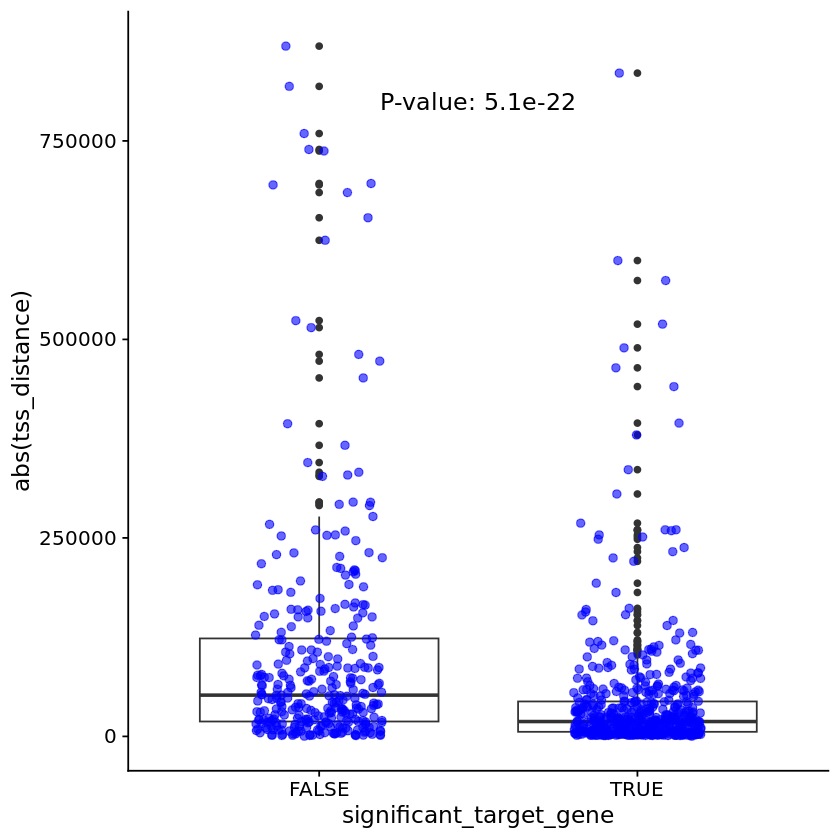

In [11]:
# Boxplot of distance to TSS of sigvs non-sig targets
temp = cres_w_grnas %>% arrange(abs(tss_distance)) %>% distinct(grna_target, .keep_all=T) %>%
    mutate(significant_target_gene 
           = ifelse(grna_target %in% cres_no_target, FALSE,TRUE))
test = wilcox.test(abs(temp$tss_distance) ~ temp$significant_target_gene)
formatted_pvalue <- format(test$p.value, scientific = TRUE, digits = 2)

#png("plots/tss_sig_vs_nonsig.png", width = 8, height = 12,units = "in", res = 300)
ggplot(temp, aes(x = significant_target_gene, y = abs(tss_distance))) +
    geom_boxplot() +
  geom_jitter(width = 0.2, size = 2, alpha = 0.6, color = "blue") +  # Adding individual values as jittered dots
  theme_cowplot() +
  annotate("text", x = 1.5, y = 800000, label = paste0("P-value: ", formatted_pvalue), size = 5, hjust = 0.5)
  #labs(title = paste(m), x = "", y = m) + coord_cartesian(ylim = c(min_value, max_value)) 
#dev.off()

In [12]:
# Bar plot of TSS
n_targets = cres_w_grnas_egene %>%
  filter(!is.na(tss_distance)) %>%
  distinct(target_gene, .keep_all = TRUE)

nrow(n_targets[n_targets$tss_distance < 100000 & n_targets$tss_distance > -100000,])/nrow(n_targets)

df1 = cres_w_grnas_egene %>%
  filter(!is.na(tss_distance)) %>%
  distinct(target_gene, .keep_all = TRUE) %>%
  mutate(bins = case_when(
    tss_distance > -1000000 & tss_distance < -900000 ~ -1000,
    tss_distance >= -900000 & tss_distance < -800000 ~ -900,
    tss_distance >= -800000 & tss_distance < -700000 ~ -800,
    tss_distance >= -700000 & tss_distance < -600000 ~ -700,
    tss_distance >= -600000 & tss_distance < -500000 ~ -600,
    tss_distance >= -500000 & tss_distance < -400000 ~ -500,
    tss_distance >= -400000 & tss_distance < -300000 ~ -400,
    tss_distance >= -300000 & tss_distance < -200000 ~ -300,
    tss_distance >= -200000 & tss_distance < -100000 ~ -200,
    tss_distance >= -100000 & tss_distance < 0 ~ -100,
    tss_distance > 0 & tss_distance < 100000 ~ 100,
    tss_distance >= 100000 & tss_distance < 200000 ~ 200,
    tss_distance >= 200000 & tss_distance < 300000 ~ 300,
    tss_distance >= 300000 & tss_distance < 400000 ~ 400,
    tss_distance >= 400000 & tss_distance < 500000 ~ 500,
    tss_distance >= 500000 & tss_distance < 600000 ~ 600,
    tss_distance >= 600000 & tss_distance < 700000 ~ 700,
    tss_distance >= 700000 & tss_distance < 800000 ~ 800,
    tss_distance >= 800000 & tss_distance < 900000 ~ 900,
    tss_distance >= 900000 & tss_distance <= 1000000 ~ 1000,
    TRUE ~ NA_real_  # Handle edge cases
  )) %>%
  group_by(bins) %>%
  summarise(n = n(),
            prop = n / nrow(n_targets),
            Gene_type = "eGene")

n_targets2 = cres_w_grnas %>%
  distinct(target_gene, .keep_all = TRUE) %>%
  filter(significant ==1)

nrow(n_targets2[n_targets2$tss_distance < 100000 & n_targets2$tss_distance > -100000,])/nrow(n_targets2)
  
df2 <- cres_w_grnas %>% 
  distinct(target_gene, .keep_all = TRUE) %>% # Remove duplicate target-genes for different eqtl/gwas
  filter(significant == 1) %>%
  mutate(bins = case_when(
    tss_distance > -1000000 & tss_distance < -900000 ~ -1000,
    tss_distance >= -900000 & tss_distance < -800000 ~ -900,
    tss_distance >= -800000 & tss_distance < -700000 ~ -800,
    tss_distance >= -700000 & tss_distance < -600000 ~ -700,
    tss_distance >= -600000 & tss_distance < -500000 ~ -600,
    tss_distance >= -500000 & tss_distance < -400000 ~ -500,
    tss_distance >= -400000 & tss_distance < -300000 ~ -400,
    tss_distance >= -300000 & tss_distance < -200000 ~ -300,
    tss_distance >= -200000 & tss_distance < -100000 ~ -200,
    tss_distance >= -100000 & tss_distance < 0 ~ -100,
    tss_distance > 0 & tss_distance < 100000 ~ 100,
    tss_distance >= 100000 & tss_distance < 200000 ~ 200,
    tss_distance >= 200000 & tss_distance < 300000 ~ 300,
    tss_distance >= 300000 & tss_distance < 400000 ~ 400,
    tss_distance >= 400000 & tss_distance < 500000 ~ 500,
    tss_distance >= 500000 & tss_distance < 600000 ~ 600,
    tss_distance >= 600000 & tss_distance < 700000 ~ 700,
    tss_distance >= 700000 & tss_distance < 800000 ~ 800,
    tss_distance >= 800000 & tss_distance < 900000 ~ 900,
    tss_distance >= 900000 & tss_distance <= 1000000 ~ 1000,
    TRUE ~ NA_real_  # Handle edge cases
  )) %>%
  group_by(bins) %>%
  summarise(
    n = n(),
    prop = n / nrow(n_targets2),
    Gene_type = "cGene"
  )

# Add a zero for -1000kb
#extra = data.frame(bins	= c(-1000,-800,-700,500,600),
#                   n = c(0,0,0,0,0),
#                   prop = c(0,0,0,0,0),
#                   Gene_type = "cGene")

png("plots/tss_distance_barplots.png", width = 8, height = 8,units = "in", res = 300)
bind_rows(df1, df2) %>% drop_na() %>%
  ggplot(aes(x = factor(bins), y = prop, fill = Gene_type)) +
  geom_col(color = "black", width = 0.8,position = position_dodge(width = 0.7)) +
  labs(x = "TSS Distance from TSS (kb)", y = "Proportion of CRE-gene pairs", fill = "Gene Type") +
  theme_cowplot() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
dev.off()

[1] 0.6838407

[1] 0.8111111

png 
  2

In [13]:
# line graph of TSS
n_targets = cres_w_grnas_egene %>%
  filter(!is.na(tss_distance), tss_distance < 100000 & tss_distance > -100000) %>%
  distinct(target_gene, .keep_all = TRUE)

nrow(n_targets[n_targets$tss_distance < 10000 & n_targets$tss_distance > -10000,])/nrow(n_targets)

df1 = cres_w_grnas_egene %>%
  filter(!is.na(tss_distance), tss_distance < 100000 & tss_distance > -100000) %>%
  distinct(target_gene, .keep_all = TRUE) %>%
  mutate(bins = case_when(
    tss_distance > -100000 & tss_distance < -90000 ~ -100,
    tss_distance >= -90000 & tss_distance < -80000 ~ -90,
    tss_distance >= -80000 & tss_distance < -70000 ~ -80,
    tss_distance >= -70000 & tss_distance < -60000 ~ -70,
    tss_distance >= -60000 & tss_distance < -50000 ~ -60,
    tss_distance >= -50000 & tss_distance < -40000 ~ -50,
    tss_distance >= -40000 & tss_distance < -30000 ~ -40,
    tss_distance >= -30000 & tss_distance < -20000 ~ -30,
    tss_distance >= -20000 & tss_distance < -10000 ~ -20,
    tss_distance >= -10000 & tss_distance < 0 ~ -10,
    tss_distance > 0 & tss_distance < 10000 ~ 10,
    tss_distance >= 10000 & tss_distance < 20000 ~ 20,
    tss_distance >= 20000 & tss_distance < 30000 ~ 30,
    tss_distance >= 30000 & tss_distance < 40000 ~ 40,
    tss_distance >= 40000 & tss_distance < 50000 ~ 50,
    tss_distance >= 50000 & tss_distance < 60000 ~ 60,
    tss_distance >= 60000 & tss_distance < 70000 ~ 70,
    tss_distance >= 70000 & tss_distance < 80000 ~ 80,
    tss_distance >= 80000 & tss_distance < 90000 ~ 90,
    tss_distance >= 90000 & tss_distance <= 100000 ~ 100,
    TRUE ~ NA_real_  # Handle edge cases
  )) %>%
  filter(!is.na(bins)) %>%  # Remove any NA bins
  group_by(bins) %>%
  summarise(n = n(),
            prop = n / nrow(n_targets),
            Gene_type = "eGene")

n_targets2 = cres_w_grnas %>%
  distinct(target_gene, .keep_all = TRUE) %>%
  filter(significant ==1, tss_distance < 100000 & tss_distance > -100000)

nrow(n_targets2[n_targets2$tss_distance < 10000 & n_targets2$tss_distance > -10000,])/nrow(n_targets2)

  
df2 <- cres_w_grnas %>% 
  distinct(target_gene, .keep_all = TRUE) %>% # Remove duplicate target-genes for different eqtl/gwas
  filter(significant == 1, tss_distance < 100000 & tss_distance > -100000) %>%
  mutate(bins = case_when(
    tss_distance > -100000 & tss_distance < -90000 ~ -100,
    tss_distance >= -90000 & tss_distance < -80000 ~ -90,
    tss_distance >= -80000 & tss_distance < -70000 ~ -80,
    tss_distance >= -70000 & tss_distance < -60000 ~ -70,
    tss_distance >= -60000 & tss_distance < -50000 ~ -60,
    tss_distance >= -50000 & tss_distance < -40000 ~ -50,
    tss_distance >= -40000 & tss_distance < -30000 ~ -40,
    tss_distance >= -30000 & tss_distance < -20000 ~ -30,
    tss_distance >= -20000 & tss_distance < -10000 ~ -20,
    tss_distance >= -10000 & tss_distance < 0 ~ -10,
    tss_distance > 0 & tss_distance < 10000 ~ 10,
    tss_distance >= 10000 & tss_distance < 20000 ~ 20,
    tss_distance >= 20000 & tss_distance < 30000 ~ 30,
    tss_distance >= 30000 & tss_distance < 40000 ~ 40,
    tss_distance >= 40000 & tss_distance < 50000 ~ 50,
    tss_distance >= 50000 & tss_distance < 60000 ~ 60,
    tss_distance >= 60000 & tss_distance < 70000 ~ 70,
    tss_distance >= 70000 & tss_distance < 80000 ~ 80,
    tss_distance >= 80000 & tss_distance < 90000 ~ 90,
    tss_distance >= 90000 & tss_distance <= 100000 ~ 100,
    TRUE ~ NA_real_  # Handle edge cases
  )) %>%
  filter(!is.na(bins)) %>%  # Remove any NA bins
  group_by(bins) %>%
  summarise(
    n = n(),
    prop = n / nrow(n_targets2),
    Gene_type = "cGene"
  )

# Add a zero for -1000kb
extra = data.frame(bins	= c(-90),
                   n = c(0),
                   prop = c(0),
                   Gene_type = "cGene")


png("plots/tss_distance_linegraph.png", width = 8, height = 8,units = "in", res = 300)
# Plot with ggplot2
bind_rows(df2,extra,df1) %>% ggplot(aes(x = bins, y = prop, group = Gene_type, color = Gene_type)) +
  geom_line(size = 1) +          # Add a line for each group
  geom_point(size = 5) +         # Add dots at each data point
  geom_vline(xintercept = 0, linetype = "dotted", color = "black", size = 0.8) + # Add a vertical dotted line at x = 0
  scale_x_continuous(
    breaks = seq(-100, 100, by = 10)
  ) +
  labs(
    title = "Proportion of eGenes by TSS Distance Bins (within 100kb)",
    x = "TSS Distance from TSS (kb)",
    y = "Proportion of CRE-gene pairs",
    color = "Gene Type"
  ) + ylim(0,0.35) +
  theme_cowplot() +              # Use a clean theme
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for better readability
  )
dev.off()


[1] 0.2597403

[1] 0.5068493

png 
  2

In [14]:
# Compare all cgenes with all egenes
# Required libraries
library(ggplot2)
library(gridExtra)

gene_metrics = fread("data/gene_metrics_vgh_202407.tsv", fill=T)
colnames(gene_metrics) = c("ensemble_id", colnames(gene_metrics)[1:15])

metrics = colnames(gene_metrics)
plot_list <- list()  # Create an empty list to store plots

for (i in 2:length(gene_metrics)){
  m = metrics[i]
  cat("Running wilcox test for", m, "\n")
  
  # Extract cgene_metric
  cgene_metric = gene_metrics[ensemble_id %in% cgenes, ..i]
  cgene_metric = na.omit(cgene_metric)
  cgene_metric <- unlist(cgene_metric)
  cgene_metric <- as.numeric(cgene_metric)
  
  # Extract egene_metric
  egene_metric = gene_metrics[ensemble_id %in% egenes, ..i]
  egene_metric = na.omit(egene_metric)
  egene_metric <- unlist(egene_metric)
  egene_metric <- as.numeric(egene_metric)
  
  # Run Wilcoxon test
  test = wilcox.test(cgene_metric, egene_metric)
  print(test)
  
  # Combine the data into a data frame for plotting
  combined_data <- data.frame(
    Gene_type = c(rep("cGene", length(cgene_metric)), rep("eGene", length(egene_metric))),
    Value = c(cgene_metric, egene_metric)
  )

  # Calculate the y-axis limits (just above the last outlier)
  stats_cgene <- boxplot.stats(cgene_metric)
  stats_egene <- boxplot.stats(egene_metric)
  
  # Max of the outliers for cgene and egene
  # Check if there are outliers; if not, use the max values from the metrics
  if (length(stats_cgene$out) > 0 | length(stats_egene$out) > 0) {
    max_outlier <- max(c(stats_cgene$out, stats_egene$out), na.rm = TRUE)
  } else {
    max_outlier <- max(c(cgene_metric, egene_metric), na.rm = TRUE)
  }
  
  # Set the lower limit as the minimum value and upper limit slightly above the max outlier
  min_value <- min(combined_data$Value, na.rm = TRUE)
  max_value <- max_outlier * 1.1  # 10% above the highest outlier

  # Create boxplot
  plot <- ggplot(combined_data, aes(x = Gene_type, y = Value, fill = Gene_type)) +
    geom_boxplot() +
  geom_jitter(width = 0.2, size = 2, alpha = 0.6, color = "blue") +  # Adding individual values as jittered dots
  theme_cowplot() +
  annotate("text", x = 1.5, y = max_value, label = paste0("P-value: ", round(test$p.value, 4)), size = 5, hjust = 0.5) +
  labs(title = paste(m), x = "", y = m) + coord_cartesian(ylim = c(min_value, max_value)) 

  # Store the plot in the plot list
  plot_list[[i - 1]] <- plot
}

png("plots/gene_metrics_boxplot_all_cgene_egene.png", width = 32, height = 10,units = "in", res = 300)
# Use grid.arrange to print all plots together
do.call(grid.arrange, c(plot_list, nrow = 2))
dev.off()

Running wilcox test for vgh 

	Wilcoxon rank sum test with continuity correction

data:  cgene_metric and egene_metric
W = 62318, p-value = 0.2742
alternative hypothesis: true location shift is not equal to 0

Running wilcox test for ncRVIS 

	Wilcoxon rank sum test with continuity correction

data:  cgene_metric and egene_metric
W = 35563, p-value = 0.04794
alternative hypothesis: true location shift is not equal to 0

Running wilcox test for loeuf_score 

	Wilcoxon rank sum test with continuity correction

data:  cgene_metric and egene_metric
W = 55038, p-value = 0.799
alternative hypothesis: true location shift is not equal to 0

Running wilcox test for ncGERP 

	Wilcoxon rank sum test with continuity correction

data:  cgene_metric and egene_metric
W = 45532, p-value = 0.418
alternative hypothesis: true location shift is not equal to 0

Running wilcox test for RVIS_score 

	Wilcoxon rank sum test with continuity correction

data:  cgene_metric and egene_metric
W = 41236, p-value = 

png 
  2

[1] 26
[1] 16

	Wilcoxon rank sum test with continuity correction

data:  cgene_metric and egene_metric
W = 78164, p-value = 0.000208
alternative hypothesis: true location shift is not equal to 0



Warning message:
“Removed 39 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 39 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 276 rows containing missing values (`geom_violin()`).”


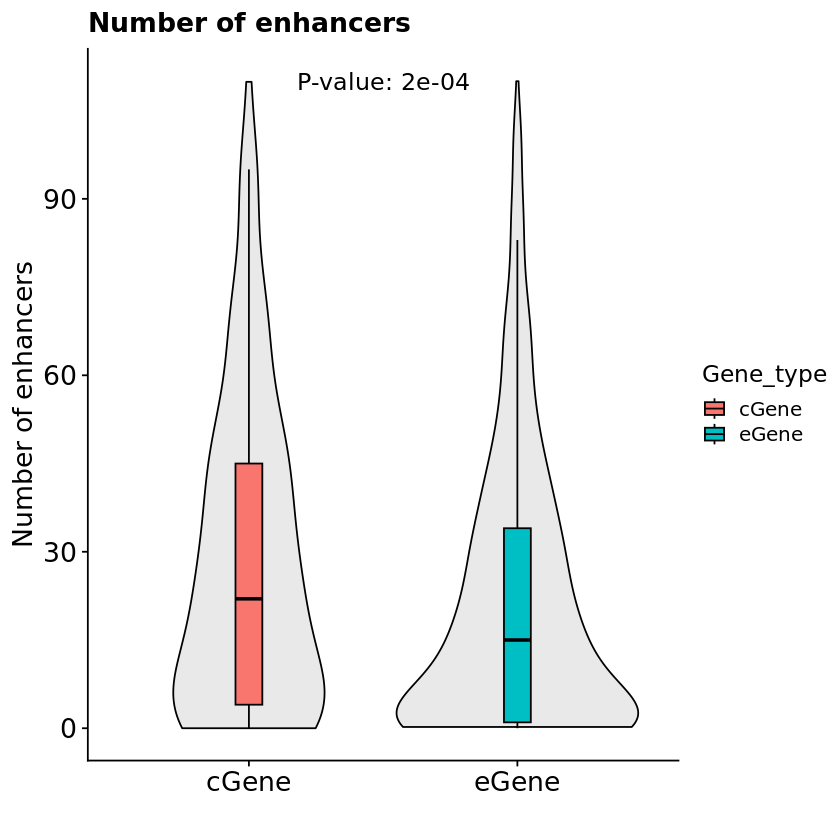

In [15]:
### Plot number of enhancers ###

# Extract cgene_metric
cgene_metric = gene_metrics[ensemble_id %in% cgenes, "num_enh"]
cgene_metric = na.omit(cgene_metric)
cgene_metric <- unlist(cgene_metric)
cgene_metric <- as.numeric(cgene_metric)
  
# Extract egene_metric
egene_metric = gene_metrics[ensemble_id %in% egenes, "num_enh"]
egene_metric = na.omit(egene_metric)
egene_metric <- unlist(egene_metric)
egene_metric <- as.numeric(egene_metric)

print(median(cgene_metric))
print(median(egene_metric))

test = wilcox.test(cgene_metric, egene_metric)
print(test)

  # Combine the data into a data frame for plotting
combined_data <- data.frame(
    Gene_type = c(rep("cGene", length(cgene_metric)), rep("eGene", length(egene_metric))),
    Value = c(cgene_metric, egene_metric)
  )

  # Calculate the y-axis limits (just above the last outlier)
stats_cgene <- boxplot.stats(cgene_metric)
stats_egene <- boxplot.stats(egene_metric)
  
  # Max of the outliers for cgene and egene
  # Check if there are outliers; if not, use the max values from the metrics
if (length(stats_cgene$out) > 0 | length(stats_egene$out) > 0) {
    max_outlier <- max(c(stats_cgene$out, stats_egene$out), na.rm = TRUE)
} else {
    max_outlier <- max(c(cgene_metric, egene_metric), na.rm = TRUE)
}
  
# Set the lower limit as the minimum value and upper limit slightly above the max outlier
min_value <- min(combined_data$Value, na.rm = TRUE)
max_value <- max_outlier * 1.1  # 10% above the highest outlier

# Generate a bar plot for gene distances
#png("plots/num_enhancers_boxplot.png", width = 6, height = 8,units = "in", res = 300)

plot <- ggplot(combined_data, aes(x = Gene_type, y = Value, fill = Gene_type)) +
  geom_violin(trim = FALSE, fill = "light grey", color = "black", alpha = 0.5) +  # Violin plot
  geom_boxplot(width = 0.1, color = "black", outlier.shape = NA) +  # Boxplot inside violin plot
  theme_cowplot() +
  ylim(0,110) +
  annotate("text", x = 1.5, y = 110, label = paste0("P-value: ", round(test$p.value, 4)), size = 5, hjust = 0.5) +
  labs(title = "Number of enhancers", x = "", y = "Number of enhancers") +
  coord_cartesian(ylim = c(min_value, 110)) +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16)
  )

plot

#dev.off()

In [16]:
### Plot pLI ###

# Extract cgene_metric
cgene_metric = gene_metrics[ensemble_id %in% cgenes, "pLI"]
cgene_metric = na.omit(cgene_metric)
cgene_metric <- unlist(cgene_metric)
cgene_metric <- as.numeric(cgene_metric)
  
# Extract egene_metric
egene_metric = gene_metrics[ensemble_id %in% egenes, "pLI"]
egene_metric = na.omit(egene_metric)
egene_metric <- unlist(egene_metric)
egene_metric <- as.numeric(egene_metric)

cgene_metric = ifelse(cgene_metric >= 0.9, 1, 0)
egene_metric = ifelse(egene_metric >= 0.9, 1, 0)

#Fisher exact test
a = sum(cgene_metric == 1)
b = sum(cgene_metric == 0)
c = sum(egene_metric == 1)
d = sum(egene_metric == 0)
print(matrix(c(a,b,c,d),nrow=2,ncol=2))
test = fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))

# Proportion of genes with pLI > 0.9
data <- data.frame(
  Gene_type = factor(c("cGene","eGene"), levels = c("cGene","eGene")),
  Proportion = c(sum(cgene_metric == 1)/length(cgene_metric),sum(egene_metric == 1)/length(egene_metric)))

# Generate a bar plot for gene distances
png("plots/pLI_barplots.png", width = 6, height = 8,units = "in", res = 300)

pli_plot = ggplot(data, aes(x = Gene_type, y = Proportion, fill = Gene_type)) +
  geom_bar(stat = "identity", color = "black", width = 0.5, position = position_dodge(width = 0.7)) +
  theme_minimal() +
  labs(title = "", x = "", y = "Proportion of genes") +
  annotate("text", x = 1.5, y = 0.31, label = paste0("P-value: ", round(test$p.value, 2)), size = 7, hjust = 0.5) +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 24),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 24)
  )

dev.off()

     [,1] [,2]
[1,]   44  155
[2,]  109  574


png 
  2

In [17]:
##############################
#### Compare HiC targets #####
##############################
hic = fread("Hi_C/K562/K562.hg19.AllInteractions.SP4.FDR0.1.txt")

intersect = fread("Hi_C/K562/cres_w_grnas_HiC_interactions.bed") %>%
  left_join(hic, "InteractorID")

# Load intersected Hi-c and grnas
cgene_hic = cres_w_grnas %>%
  filter(significant ==1) %>%
  left_join(intersect,"grna_target", relationship = "many-to-many") %>%
  filter(is.na(InteractorID)==F)

# Load intersected Hi-c and grnas
egene_hic = cres_w_grnas_egene %>%
  left_join(intersect,"grna_target", relationship = "many-to-many") %>%
  filter(is.na(InteractorID)==F)

# Fisher exact test
#                       cgene                      egene
# HiCoverlap              a                          b
# HiC non-overlap         c                          d

overlaping_cgenes = length(unique(cgene_hic$target_gene[cgene_hic$gene_name == cgene_hic$RefSeqName]))
overlaping_egenes = length(unique(egene_hic$target_gene[egene_hic$gene_name == egene_hic$RefSeqName]))
total_cgene_targets = length(unique(cres_w_grnas$target_gene[cres_w_grnas$significant == 1]))
total_egene_targets = length(unique(cres_w_grnas_egene$target_gene))

total_cgene_targets

a = overlaping_cgenes
b = overlaping_egenes
c = total_cgene_targets-overlaping_cgenes
d = total_egene_targets-overlaping_egenes

print(matrix(c(a,b,c,d),nrow=2,ncol=2))
test = fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))

# Proportion of genes with pLI > 0.9
data <- data.frame(
  Gene_type = factor(c("cGene","eGene"), levels = c("cGene","eGene")),
  Proportion = c(overlaping_cgenes/total_cgene_targets,overlaping_egenes/total_egene_targets))

# Generate a bar plot for gene distances
png("plots/HiC_barplots.png", width = 6, height = 8,units = "in", res = 300)

ggplot(data, aes(x = Gene_type, y = Proportion, fill = Gene_type)) +
  geom_bar(stat = "identity", color = "black", width = 0.5, position = position_dodge(width = 0.7)) +
  theme_minimal() +
  labs(title = "", x = "", y = "Proportion of CRE-gene targets") +
  annotate("text", x = 1.5, y = 0.31, label = paste0("P-value: ", round(test$p.value, 5)), size = 7, hjust = 0.5) +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 24),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 24)
  )

dev.off()

Warning message in left_join(., hic, "InteractorID"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 3 of `x` matches multiple rows in `y`.
ℹ Row 2165 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


[1] 180

     [,1] [,2]
[1,]   42  138
[2,]  143 1157


png 
  2

In [18]:
K562_bulk = fread("/gpfs/commons/groups/lappalainen_lab/jmorris/210205_STINGseq-v2/data/K562_scRNAseq_bulkRNAseq.txt") %>%
  mutate(ensembl_gene_id = str_split_fixed(ENSG, "\\.",2)[,1])

# Extract cgene_metric
cgene_metric = K562_bulk$TPM[K562_bulk$ensembl_gene_id %in% cgenes & !K562_bulk$ensembl_gene_id %in% egenes]
cgene_metric <- unlist(cgene_metric)
cgene_metric <- as.numeric(cgene_metric)
  
# Extract egene_metric
egene_df = data.frame(ensembl_gene_id = egenes) %>%
  left_join(K562_bulk[,c("ensembl_gene_id","TPM")], "ensembl_gene_id")
egene_df[is.na(egene_df)] = 0
egene_metric <- unlist(egene_df$TPM[!egene_df$ensembl_gene_id %in% cgenes])
egene_metric <- as.numeric(egene_metric)

# Extract both metric
  
# Run Wilcoxon test
median(cgene_metric)
median(egene_metric)
test = wilcox.test(cgene_metric, egene_metric)
print(test)

# Combine the data into a data frame for plotting
combined_data <- data.frame(
    Gene_type = c(rep("cgenes", length(cgene_metric)), rep("egenes", length(egene_metric))),
    Value = c(cgene_metric, egene_metric))

[1] 18.0953

[1] 2.865715


	Wilcoxon rank sum test with continuity correction

data:  cgene_metric and egene_metric
W = 48920, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 402 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 402 rows containing non-finite values (`stat_boxplot()`).”


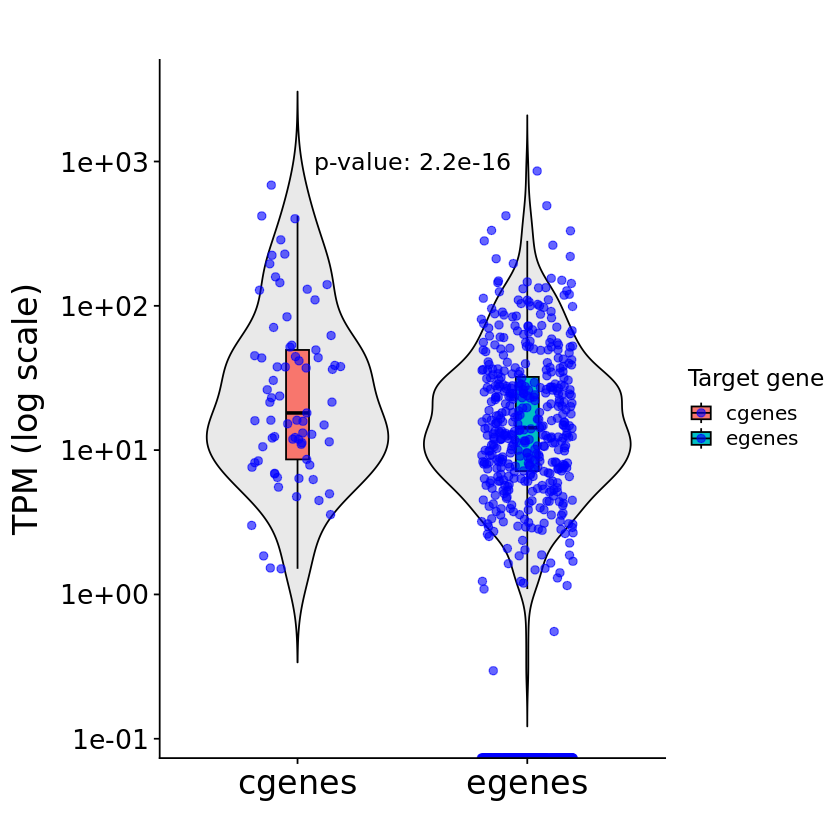

In [19]:
# Create boxplot
plot2 <- combined_data %>%
  ggplot(aes(x = Gene_type, y = Value, fill = Gene_type)) +
  geom_violin(trim = FALSE, fill = "light grey", color = "black", alpha = 0.5) +  # Violin plot
  geom_boxplot(width = 0.1, color = "black", outlier.shape = NA) +  # Boxplot inside violin plot
  geom_jitter(width = 0.2, size = 2, alpha = 0.6, color = "blue") +  # Adding individual values as jittered dots
  scale_y_continuous(trans = 'log10') +
  theme_cowplot() +
  annotate("text", x = 1.5, y = 1000, label = paste0("p-value: ", formatC(test$p.value, format = "e", digits = 1)), size = 5, hjust = 0.5) +
  labs(title = "", x = "", y = "TPM (log scale)",  fill = "Target gene") +
  theme(
      plot.title = element_text(size = 20, face = "plain", margin = margin(b = 10), hjust = 0),
      axis.title.y = element_text(size = 20, margin = margin(r = 10)),
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 16)
  )

#png("plots/Expression_boxplots.png", width = 8, height = 8,units = "in", res = 300)
plot2
#dev.off()

Warning message:
“Removed 20 rows containing non-finite values (`stat_density()`).”


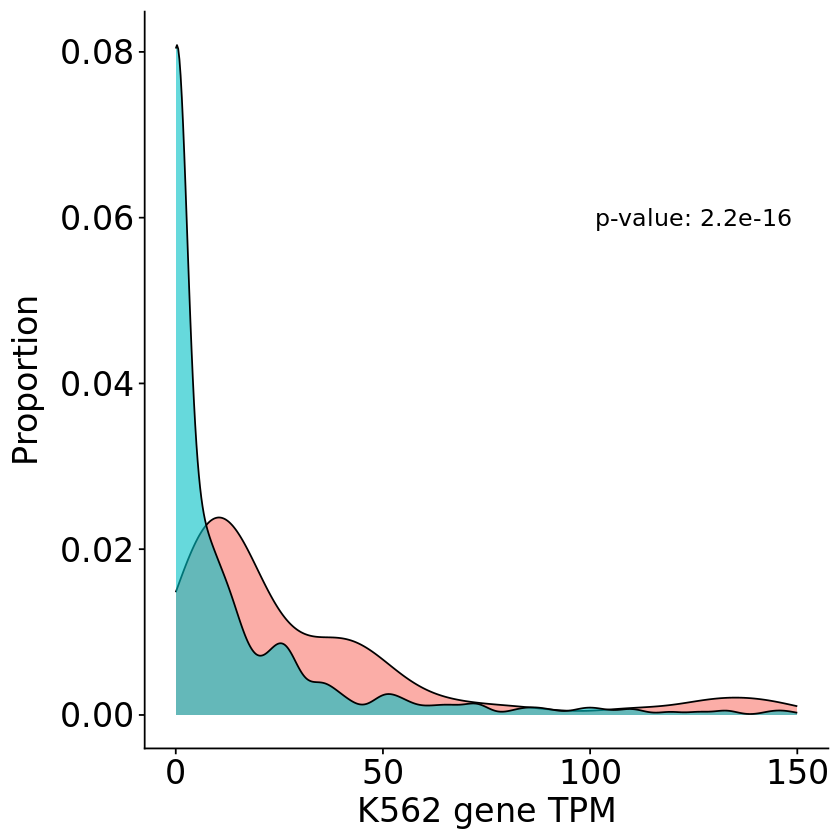

In [20]:
# Plot with vertical lines for medians
density1 = ggplot(combined_data, aes(x = Value, fill = Gene_type)) +
  geom_density(alpha = 0.6) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +  # Set colors to red and blue
  theme_cowplot() +
  annotate("text", x = 125, y = 0.06, label = paste0("p-value: ", formatC(test$p.value, format = "e", digits = 1)), size = 5, hjust = 0.5) +
  xlim(0, 150) +
  theme(
      legend.position="none",
      legend.title = element_blank(),
      plot.title = element_text(size = 20, face = "plain", margin = margin(b = 10), hjust = 0),
      axis.title.y = element_text(size = 20, margin = margin(r = 10)),
      axis.text.x = element_text(size = 20),
      axis.title.x = element_text(size=20),
      axis.text.y = element_text(size = 20)
  ) +
  ylab("Proportion") +
  xlab("K562 gene TPM")
density1

[1] 12.7508

[1] 5.03962


	Wilcoxon rank sum test with continuity correction

data:  cgene_metric and egene_metric
W = 45415, p-value = 0.001545
alternative hypothesis: true location shift is not equal to 0



Warning message:
“Removed 63 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 20 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 63 rows containing non-finite values (`stat_density()`).”


png 
  2

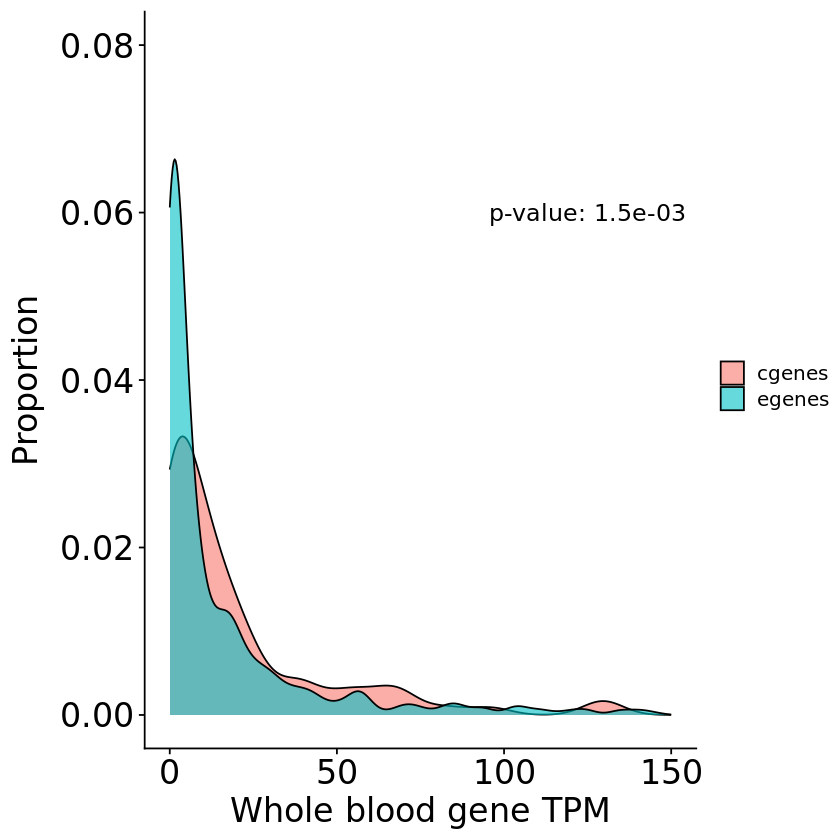

In [21]:
blood_tpm = fread("data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz")[, c("Name", "Whole Blood"), with = FALSE]
blood_tpm$Name = str_split_fixed(blood_tpm$Name, "\\.", 2)[,1]

# Extract cgene_metric
cgene_metric = blood_tpm$`Whole Blood`[blood_tpm$Name %in% cgenes & !blood_tpm$Name %in% egenes]
cgene_metric <- unlist(cgene_metric)
cgene_metric <- as.numeric(cgene_metric)
  
# Extract egene_metric
egene_metric = blood_tpm$`Whole Blood`[blood_tpm$Name %in% egenes & !blood_tpm$Name %in% cgenes]
egene_metric <- unlist(egene_metric)
egene_metric <- as.numeric(egene_metric)

# Extract both metric
  
# Run Wilcoxon test
median(cgene_metric)
median(egene_metric)
test = wilcox.test(cgene_metric, egene_metric)
print(test)

# Combine the data into a data frame for plotting
combined_data <- data.frame(
    Gene_type = c(rep("cgenes", length(cgene_metric)), rep("egenes", length(egene_metric))),
    Value = c(cgene_metric, egene_metric))

# Plot with vertical lines for medians
density2 = ggplot(combined_data, aes(x = Value, fill = Gene_type)) +
  geom_density(alpha = 0.6) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +  # Set colors to red and blue
  theme_cowplot() +
  annotate("text", x = 125, y = 0.06, label = paste0("p-value: ", formatC(test$p.value, format = "e", digits = 1)), size = 5, hjust = 0.5) +
  xlim(0, 150) +
  ylim(0,0.08) +
  theme(
      legend.title = element_blank(),
      plot.title = element_text(size = 20, face = "plain", margin = margin(b = 10), hjust = 0),
      axis.title.y = element_text(size = 20, margin = margin(r = 10)),
      axis.title.x = element_text(size=20),
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)
  ) +
  ylab("Proportion") +
  xlab("Whole blood gene TPM")

density2

png("plots/Expression_histograms.png", width = 16, height = 10,units = "in", res = 300)
grid.arrange(density1, density2, ncol = 2)
dev.off()

In [22]:
#######################################################
### Do intersecting egenes have larger effect sizes ###
#######################################################
egenes_int = egenes[egenes %in% cgenes]
egenes_non_int = egenes[!egenes %in% cgenes]
eqtls_int = cres_w_grnas_egene %>% filter(ensembl_id %in% egenes_int) %>% distinct(target_gene, .keep_all=T)
eqtls_non_int = cres_w_grnas_egene %>% filter(!ensembl_id %in% egenes_int) %>% distinct(target_gene, .keep_all=T)
test = wilcox.test(eqtls_int$beta, eqtls_non_int$beta)
print(test)
  combined_data <- data.frame(
    Method = c(rep("Intersecting", nrow(eqtls_int)), rep("Non-Intersecting", nrow(eqtls_non_int))),
    Value = c(eqtls_int$beta, eqtls_non_int$beta)
  )

  # Create boxplot
  plot2 <- ggplot(combined_data, aes(x = Gene_type, y = abs(Value), fill = Gene_type)) +
    geom_boxplot() +
  geom_jitter(width = 0.2, size = 2, alpha = 0.6, color = "blue") +  # Adding individual values as jittered dots
  theme_cowplot() +
  annotate("text", x = 1.5, y = 2, label = paste0("P-value: ", round(test$p.value, 4)), size = 5, hjust = 0.5) +
  labs(title = "eQTL effect sizes", x = "", y = "Effect size") + coord_cartesian(ylim = c(0, 2))


	Wilcoxon rank sum test with continuity correction

data:  eqtls_int$beta and eqtls_non_int$beta
W = 67716, p-value = 0.9961
alternative hypothesis: true location shift is not equal to 0



In [23]:
#####################################################################
### Calculate the number of genes within 1mbp of overlapping CREs ###
#####################################################################
gene_ann_grc37 = fread("data/gencode.v19.annotation.gtf.gz", header = F)
extracted_ids <- gsub('.*gene_id "([A-Z0-9.]+)".*', '\\1', gene_ann_grc37$V9)
# Remove the version part (e.g., ".4")
extracted_ids_clean <- gsub("\\..*", "", extracted_ids)
# Display the extracted IDs
gene_ann_grc37$ensembl_gene_id = extracted_ids_clean

gene_positions = gene_ann_grc37[,c("V1","V4","V5","V7","ensembl_gene_id")]
colnames(gene_positions)[1:4] = c("chr","start","end","strand")
gene_positions$tss <- ifelse(gene_positions$strand == "+", gene_positions$start, gene_positions$end)

K562_bulk = fread("/gpfs/commons/groups/lappalainen_lab/jmorris/210205_STINGseq-v2/data/K562_scRNAseq_bulkRNAseq.txt") %>%
  mutate(ensembl_gene_id = str_split_fixed(ENSG, "\\.",2)[,1]) %>% left_join(gene_positions, "ensembl_gene_id")

In [24]:
find_genes = function(chr, pos, grna_target){
  
  Chr=paste0("chr",chr)
  upper = pos+1000000
  lower = pos-1000000
  
  nearby_genes = K562_bulk[chr == Chr & inrange(tss, lower,upper),] %>% distinct(ensembl_gene_id,.keep_all=T) %>%
    mutate(distance = abs(tss-pos), grna_target = grna_target, target_gene = paste0(grna_target,"_",ensembl_gene_id))
  
  return(nearby_genes)
}

temp = cres_w_grnas[cres_w_grnas$grna_target %in% overlapping_cres,] %>% distinct(grna_target, .keep_all=T)
all_gene_targets = lapply(1:nrow(temp), function(x) find_genes(temp$chr[x],temp$grna_pos[x],temp$grna_target[x]))
all_gene_targets = do.call(rbind, all_gene_targets)
all_gene_targets$genes_overlap = ifelse(all_gene_targets$target_gene %in% overlapping_target_genes,1,0)
all_gene_targets$egene = as.factor(ifelse(all_gene_targets$target_gene %in% overlapping_cres_egene,1,0))
all_gene_targets$cgene = as.factor(ifelse(all_gene_targets$target_gene %in% overlapping_cres_cgene,1,0))

In [25]:
# Write k562 cis-genes to file
fwrite(all_gene_targets[,"ENSG"], "data/k562_cis_genes.txt", row.names = F, quote = F)

In [26]:
# Calculate enrichment for all genes within 1mbp
#                                 sig-target cgene           non-sig target cgene
# sig target-egene              a                          b
# non-sig target-egene          c                          d

a = length(overlapping_target_genes)
b = length(overlapping_cres_egene) - length(overlapping_target_genes)
c = length(overlapping_cres_cgene) - length(overlapping_target_genes)
d = nrow(all_gene_targets) - (a+b+c)
print(matrix(c(a,b,c,d),nrow=2,ncol=2))
test = fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))


print(test$p.value)

     [,1] [,2]
[1,]   69   53
[2,]  197 1240
[1] 2.10437e-25


In [27]:
# Calculate enrichment for all genes within 500kbp
overlapping_cres_cgene_500kbp = unique(cres_w_grnas$target_gene[cres_w_grnas$grna_target %in% overlapping_cres & cres_w_grnas$significant == 1 & cres_w_grnas$tss_distance < 500000])
length(overlapping_cres_cgene_500kbp)
overlapping_cres_egene_500kbp = unique(cres_w_grnas_egene$target_gene[cres_w_grnas_egene$grna_target %in% overlapping_cres & cres_w_grnas_egene$tss_distance < 500000])
length(overlapping_cres_egene_500kbp)
overlapping_target_genes_500kbp = overlapping_cres_cgene_500kbp[overlapping_cres_cgene_500kbp %in% overlapping_cres_egene_500kbp]
a = length(overlapping_target_genes_500kbp)
b = length(overlapping_cres_egene_500kbp) - a
c = length(overlapping_cres_cgene_500kbp) - a
d = nrow(all_gene_targets[distance<500000]) - (a+b+c)
print(matrix(c(a,b,c,d),nrow=2,ncol=2))
fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))

[1] 116

[1] 254

     [,1] [,2]
[1,]   69   47
[2,]  185  642



	Fisher's Exact Test for Count Data

data:  matrix(c(a, b, c, d), nrow = 2, ncol = 2)
p-value = 2.646e-15
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.331636 7.814680
sample estimates:
odds ratio 
  5.083646 


In [28]:
# Calculate enrichment for all genes within 250kbp
overlapping_cres_cgene_250kbp = unique(cres_w_grnas$target_gene[cres_w_grnas$grna_target %in% overlapping_cres & cres_w_grnas$significant == 1 & cres_w_grnas$tss_distance < 250000])
length(overlapping_cres_cgene_250kbp)
overlapping_cres_egene_250kbp = unique(cres_w_grnas_egene$target_gene[cres_w_grnas_egene$grna_target %in% overlapping_cres & cres_w_grnas_egene$tss_distance < 250000])
length(overlapping_cres_egene_250kbp)
overlapping_target_genes_250kbp = overlapping_cres_cgene_250kbp[overlapping_cres_cgene_250kbp %in% overlapping_cres_egene_250kbp]
a = length(overlapping_target_genes_250kbp)
b = length(overlapping_cres_egene_250kbp) - a
c = length(overlapping_cres_cgene_250kbp) - a
d = nrow(all_gene_targets[distance<250000]) - (a+b+c)
print(matrix(c(a,b,c,d),nrow=2,ncol=2))
fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))# Load ggplot2

[1] 115

[1] 246

     [,1] [,2]
[1,]   69   46
[2,]  177  310



	Fisher's Exact Test for Count Data

data:  matrix(c(a, b, c, d), nrow = 2, ncol = 2)
p-value = 4.876e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.698075 4.080398
sample estimates:
odds ratio 
  2.622695 


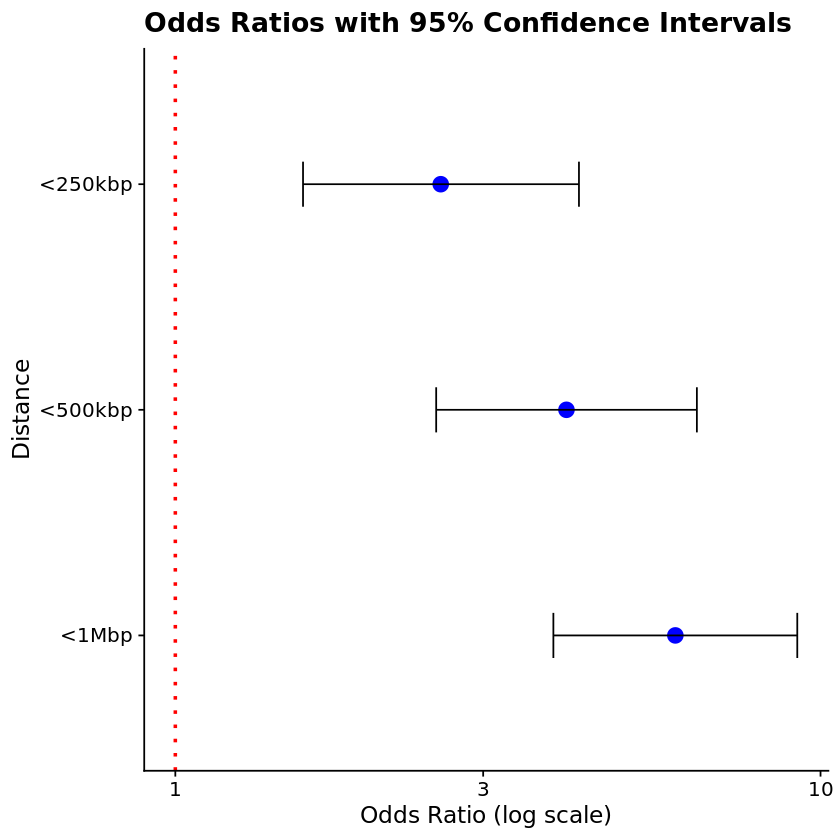

In [29]:
library(ggplot2)
library(cowplot)

# Create a data frame with odds ratio and confidence intervals
data <- data.frame(
  Distance = c("<1Mbp", "<500kbp", "<250kbp"),
  OddsRatio = c(5.956461, 4.038529,   2.578426 ),
  LowerCI = c(3.854193, 2.536900, 1.577351),  # Lower bound of 95% CI
  UpperCI = c(9.203654, 6.432076, 4.222648)  # Upper bound of 95% CI
)

# Order the Distance factor from largest to smallest distance
data$Distance <- factor(data$Distance, levels = c("<1Mbp", "<500kbp", "<250kbp"))

# Create a forest plot using ggplot2 and flip the axes
ggplot(data, aes(x = OddsRatio, y = Distance)) +
  geom_point(size = 4, color = "blue") +  # Points for the odds ratio
  geom_vline(xintercept = 1, linetype = "dotted", color = "red", size = 1) +  # Add a dotted line at OR = 1
  geom_errorbarh(aes(xmin = LowerCI, xmax = UpperCI), height = 0.2, color = "black") +  # Horizontal error bars for 95% CI
  scale_x_continuous(trans = 'log10') +  # Log scale for odds ratio
  labs(title = "Odds Ratios with 95% Confidence Intervals",
       x = "Odds Ratio (log scale)",
       y = "Distance") +
  theme_cowplot()

     [,1] [,2]
[1,]  121   24
[2,]  370  145
     [,1] [,2]
[1,]   20  125
[2,]  176  339
     [,1] [,2]
[1,]   34  111
[2,]  317  198


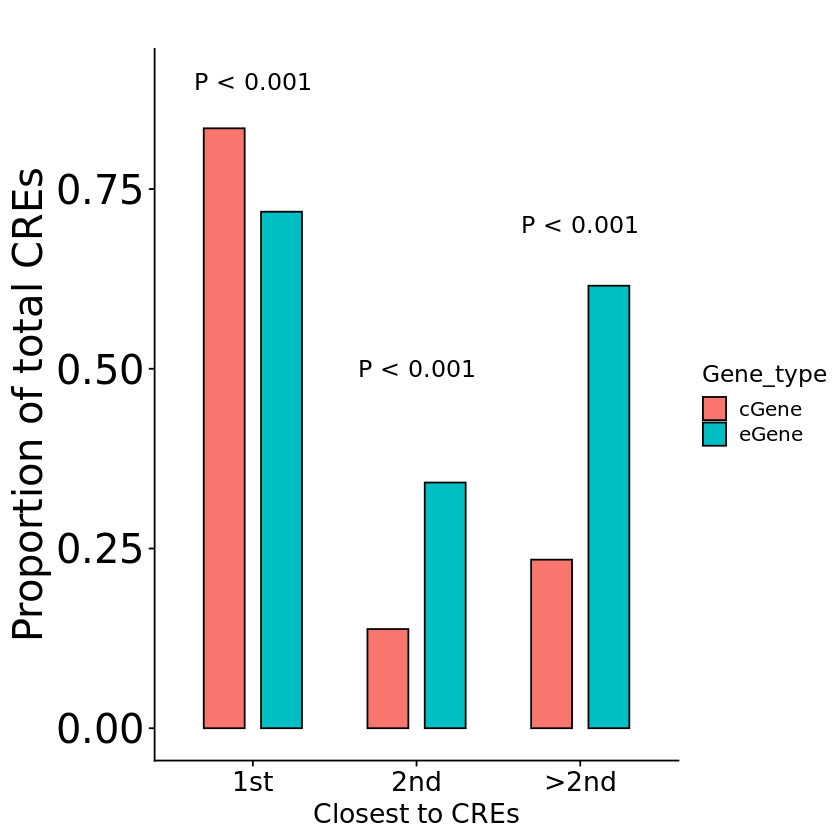

In [30]:
# Calculate proportion of significant genes in each CRE
closest_cgene = cres_w_grnas %>% distinct(target_gene, .keep_all=T) %>% # Remove duplicate target-genes for different eqtl/gwas
 group_by(grna_target) %>% mutate(dis_rank = rank(abs(tss_distance))) %>% filter(significant ==1)
one_cgene = length(unique(closest_cgene$grna_target[closest_cgene$dis_rank ==1]))/length(unique(closest_cgene$grna_target))
two_cgene = length(unique(closest_cgene$grna_target[closest_cgene$dis_rank ==2]))/length(unique(closest_cgene$grna_target))
three_cgene = length(unique(closest_cgene$grna_target[closest_cgene$dis_rank > 2]))/length(unique(closest_cgene$grna_target))
# Same for eqtl
closest_egene = cres_w_grnas_egene %>% filter(is.na(dis_rank) ==F) %>% arrange(dis_rank) %>% distinct(target_gene, .keep_all=T)
one_egene = length(unique(closest_egene$grna_target[closest_egene$dis_rank ==1]))/length(unique(closest_egene$grna_target))
two_egene = length(unique(closest_egene$grna_target[closest_egene$dis_rank ==2]))/length(unique(closest_egene$grna_target))
three_egene = length(unique(closest_egene$grna_target[closest_egene$dis_rank >2]))/length(unique(closest_egene$grna_target))

# Fisher test for closest gene
a = length(unique(closest_cgene$grna_target[closest_cgene$dis_rank ==1]))
b = length(unique(closest_egene$grna_target[closest_egene$dis_rank ==1]))
c = length(unique(closest_cgene$grna_target)) - a
d = length(unique(closest_egene$grna_target)) - b
print(matrix(c(a,b,c,d),nrow=2,ncol=2))
test = fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))# Load ggplot2

# Fisher test for 2nd gene
a = length(unique(closest_cgene$grna_target[closest_cgene$dis_rank ==2]))
b = length(unique(closest_egene$grna_target[closest_egene$dis_rank ==2]))
c = length(unique(closest_cgene$grna_target)) - a
d = length(unique(closest_egene$grna_target)) - b
print(matrix(c(a,b,c,d),nrow=2,ncol=2))
test2 = fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))# Load ggplot2

# Fisher test for 3rd gene
a = length(unique(closest_cgene$grna_target[closest_cgene$dis_rank > 2]))
b = length(unique(closest_egene$grna_target[closest_egene$dis_rank >2]))
c = length(unique(closest_cgene$grna_target)) - a
d = length(unique(closest_egene$grna_target)) - b
print(matrix(c(a,b,c,d),nrow=2,ncol=2))
test3 = fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))# Load ggplot2

# Barplot of gene distances
data <- data.frame(
  Rank = factor(c("1st","1st","2nd","2nd",">2nd", ">2nd"), levels = c("1st", "2nd", ">2nd")),
  Gene_type = c(rep(c("cGene", "eGene"),3)),
  percent = c(one_cgene,one_egene,two_cgene,two_egene,
              three_cgene,three_egene))

# Generate a bar plot for gene distances
#png("plots/all_crispr_closest_gene_barplot.png", width = 6, height = 8,units = "in", res = 300)

ggplot(data, aes(x = Rank, y = percent, fill = Gene_type)) +
  geom_bar(stat = "identity", color = "black", width = 0.5, position = position_dodge(width = 0.7)) +
  theme_minimal() +
  labs(title = "", x = "Closest to CREs", y = "Proportion of total CREs") +
  annotate("text", x = 1, y = 0.90, label = "P < 0.001", size = 5, hjust = 0.5) +
  annotate("text", x = 2, y = 0.50, label = "P < 0.001", size = 5, hjust = 0.5) +
  annotate("text", x = 3, y = 0.70, label = "P < 0.001", size = 5, hjust = 0.5) +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 24),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 24)
  )

#dev.off()

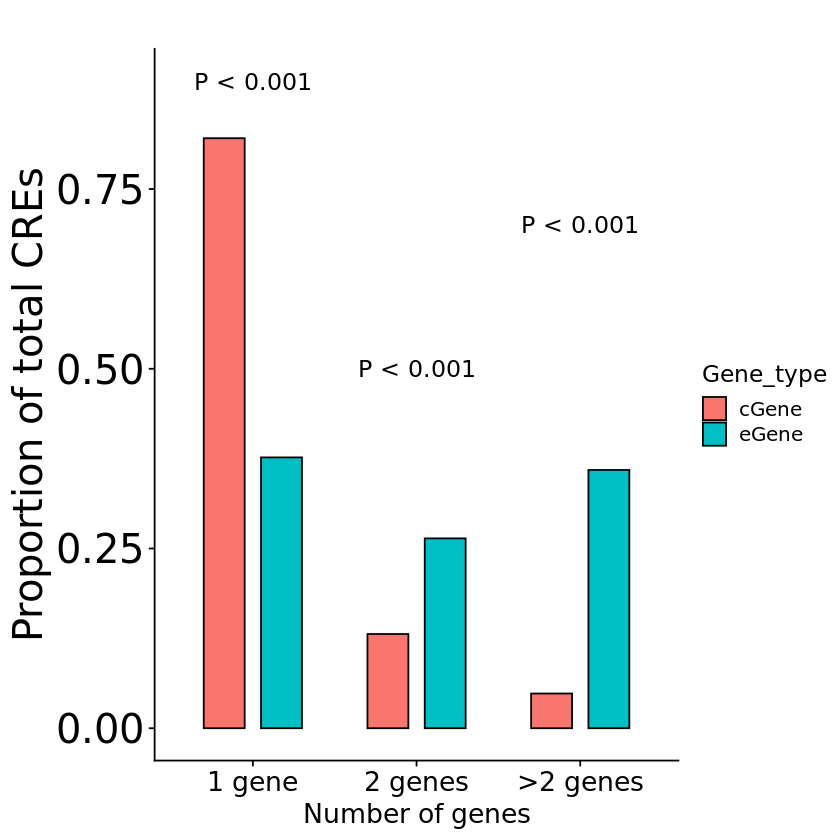

In [31]:
#############################################################
### Barplot of the number of genes associated at each CRE ###
#############################################################
cgenes_per_cre = cres_w_grnas %>% filter(significant ==1) %>% distinct(target_gene, .keep_all=T) %>% group_by(grna_target) %>% 
    summarise(n = n())
egenes_per_cre = cres_w_grnas_egene %>% distinct(target_gene, .keep_all=T) %>% group_by(grna_target) %>% 
    summarise(n = n())

# Barplot of gene distances
data <- data.frame(
  n_Genes = factor(c("1 gene","1 gene","2 genes","2 genes",">2 genes", ">2 genes"), levels = c("1 gene", "2 genes", ">2 genes")),
  Gene_type = c(rep(c("cGene", "eGene"),3)),
  Proportion = c(sum(cgenes_per_cre$n ==1)/nrow(cgenes_per_cre),
              sum(egenes_per_cre$n ==1)/nrow(egenes_per_cre),
              sum(cgenes_per_cre$n ==2)/nrow(cgenes_per_cre),
              sum(egenes_per_cre$n ==2)/nrow(egenes_per_cre),
              sum(cgenes_per_cre$n > 2)/nrow(cgenes_per_cre),
              sum(egenes_per_cre$n > 2)/nrow(egenes_per_cre)))

# Generate a bar plot for gene distances
#png("plots/all_crispr_number_of_genes_barplot.png", width = 6, height = 8,units = "in", res = 300)

ggplot(data, aes(x = n_Genes, y = Proportion, fill = Gene_type)) +
  geom_bar(stat = "identity", color = "black", width = 0.5, position = position_dodge(width = 0.7)) +
  theme_minimal() +
  labs(title = "", x = "Number of genes", y = "Proportion of total CREs") +
  annotate("text", x = 1, y = 0.90, label = "P < 0.001", size = 5, hjust = 0.5) +
  annotate("text", x = 2, y = 0.50, label = "P < 0.001", size = 5, hjust = 0.5) +
  annotate("text", x = 3, y = 0.70, label = "P < 0.001", size = 5, hjust = 0.5) +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 24),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 24)
  )

#dev.off()

In [32]:
#####################################################################
### Multi-variate logistic regression model for gene intersection ###
#####################################################################
non_int_egene = cres_w_grnas_egene[cres_w_grnas_egene$target_gene %in% overlapping_cres_egene & !cres_w_grnas_egene$target_gene %in% overlapping_target_genes,]
length(unique(non_int_egene$ensembl_id))

non_int_cgene = cres_w_grnas[cres_w_grnas$target_gene %in% overlapping_cres_cgene & !cres_w_grnas$target_gene %in% overlapping_target_genes & cres_w_grnas$significant == 1,]
length(unique(non_int_cgene$ensembl_id))

# Number eqtl genes not expressed in k562
sum(!unique(non_int_egene$ensembl_id) %in% cres_w_grnas$ensembl_id)

# Load genes expressed within 1mb of eqtl cell types
onek_gene_distances = fread("eQTL_gene_distances/Onek1k_gene_distance.txt")
mage_gene_distances = fread("eQTL_gene_distances/MAGE_gene_distance.txt") %>%
  mutate(ensembl_id = str_split_fixed(ensemblID, "\\.",2)[,1],
         unique_id = paste0(chr,":",upper_hg19,ensembl_id))
gtex_gene_distances = fread("eQTL_gene_distances/GTEx_gene_distance.txt") %>%
  mutate(ensembl_id = str_split_fixed(phenotype_id, "\\.",2)[,1],
         unique_id = paste0(grna_target,ensembl_id))
cat_sumstats = fread("eQTL_gene_distances/eqtl_cat_gene_distances.txt") %>%
  mutate(unique_id = paste0(variant,molecular_trait_id,eqtl), ensembl_id = molecular_trait_id)

sum(!unique(non_int_cgene$ensembl_id) %in% c(mage_gene_distances$ensembl_id, gtex_gene_distances$ensembl_id, cat_sumstats$ensembl_id))

all_cgenes = cres_w_grnas$ensembl_id
all_egenes = unique(c(mage_gene_distances$ensembl_id, gtex_gene_distances$ensembl_id, cat_sumstats$ensembl_id, onek_gene_distances$ensembl_id))
intersecting_genes = unique(cres_w_grnas_egene$ensembl_id[cres_w_grnas_egene$grna_target %in% overlapping_cres])
non_intersecting_genes = unique(c(non_int_egene$ensembl_id,non_int_cgene$ensembl_id))

## logistic regression
colnames(gene_metrics)[1] = "ensembl_id"
colnames(blood_tpm) = c("ensembl_id","whl_bld_tpm")

# Load rare genes
rare_genes = fread("rare_genes_list.txt")

# regression
regression_df = cres_w_grnas_egene %>% left_join(blood_tpm, "ensembl_id") %>% 
    mutate(chr = str_split_fixed(cres_w_grnas_egene$finemap_snp_intersect_grna, ":", 4)[, 1]) %>%
    mutate(snp_pos = paste0(chr, ":", str_split_fixed(cres_w_grnas_egene$finemap_snp_intersect_grna, ":", 4)[, 2])) %>% # Make snp pos coord to join power
    mutate(gwas_pval = ifelse(gwas_pval == 0, 2.53951e-304, gwas_pval)) %>% # recode small pvalues
    mutate(gene_intersect = as.factor(ifelse(target_gene %in% overlapping_target_genes,1,0))) %>%
    mutate(eqtl_log_pvalue = -log10(pval_nominal), gwas_log_pvalue = -log10(gwas_pval)) %>% 
    group_by(target_gene) %>% mutate(mean_PP.H4 = mean(PP.H4.abf,na.rm=T), mean_gwas_pval = mean(gwas_log_pvalue, na.rm=T)) %>% # Take the average PP.H4 from multiple GWAS
    mutate(scaled_mean_PP.H4 = mean_PP.H4*2, tss_distance_100kbp = abs(tss_distance/100000)*-1, log_median_tpm = log(median_tpm + 1)) %>% # scale pp.h4 so that 0.5 is one unit change
    distinct(target_gene,.keep_all=T) %>% ungroup() %>% left_join(gene_metrics, "ensembl_id") %>%
    mutate(median_tpm = ifelse(is.na(median_tpm.x), whl_bld_tpm, median_tpm.x)) %>% # if na make whlbld
    mutate(pLI = as.factor(ifelse(pLI >= 0.9,1,0)), gold_standard = ifelse(ensembl_id %in% rare_genes$rare_genes,1,0))

library(glmnet)
fit = glm(gene_intersect ~ scaled_mean_PP.H4 + Episcore + abs(tss_distance_100kbp) + as.factor(gold_standard) + median_tpm + eqtl_log_pvalue + mean_gwas_pval + pLI + num_enh
          , regression_df, family = "binomial")
# additional varibales that lower the number of observations: + pLI + num_enh + beta_0.3

fit_summary <- summary(fit)
fit_summary
pvalue = fit_summary$coefficients[2, "Pr(>|z|)"]
OR = exp(fit_summary$coefficients[2,1])

[1] 189

[1] 49

[1] 71

[1] 5

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8




Call:
glm(formula = gene_intersect ~ scaled_mean_PP.H4 + Episcore + 
    abs(tss_distance_100kbp) + as.factor(gold_standard) + median_tpm + 
    eqtl_log_pvalue + mean_gwas_pval + pLI + num_enh, family = "binomial", 
    data = regression_df)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -6.320e+00  1.104e+00  -5.722 1.05e-08 ***
scaled_mean_PP.H4          2.010e+00  6.242e-01   3.220  0.00128 ** 
Episcore                   1.771e+00  6.419e-01   2.759  0.00579 ** 
abs(tss_distance_100kbp)  -4.619e-01  1.801e-01  -2.565  0.01031 *  
as.factor(gold_standard)1  7.274e-01  4.246e-01   1.713  0.08670 .  
median_tpm                -6.941e-05  2.204e-04  -0.315  0.75280    
eqtl_log_pvalue           -2.325e-03  9.024e-03  -0.258  0.79663    
mean_gwas_pval            -9.687e-03  8.351e-03  -1.160  0.24606    
pLI1                       1.747e-02  3.187e-01   0.055  0.95628    
num_enh                    3.031e-03  3.065e-03   0

Variable,Estimate,StdError,PValue,OR,CI_lower,CI_upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Posterior Probability (PP.H4),2.010e+00,0.6242000,0.00128,7.4633173,2.1958473,25.3665658
Episcore,1.771e+00,0.6419000,0.00579,5.8767272,1.6700875,20.6791098
Distance to TSS (100kbp),-4.620e-01,0.1801000,0.01031,0.6300223,0.4426411,0.8967268
Gold Standard Gene,7.270e-01,0.4246000,0.08670,2.0688647,0.9001301,4.7550918
Median TPM,-6.941e-05,0.0002204,0.75280,0.9999306,0.9994987,1.0003626
eQTL -log10(p-value),-2.325e-03,0.0090240,0.79663,0.9976777,0.9801869,1.0154806
GWAS -log10(p-value),-9.687e-03,0.0083510,0.24606,0.9903598,0.9742815,1.0067033
pLI Score,1.747e-02,0.3187000,0.95628,1.0176235,0.5448842,1.9005095
Number of Enhancers,3.031e-03,0.0030650,0.32265,1.0030356,0.9970280,1.0090794


Warning message:
“Duplicated aesthetics after name standardisation: colour”


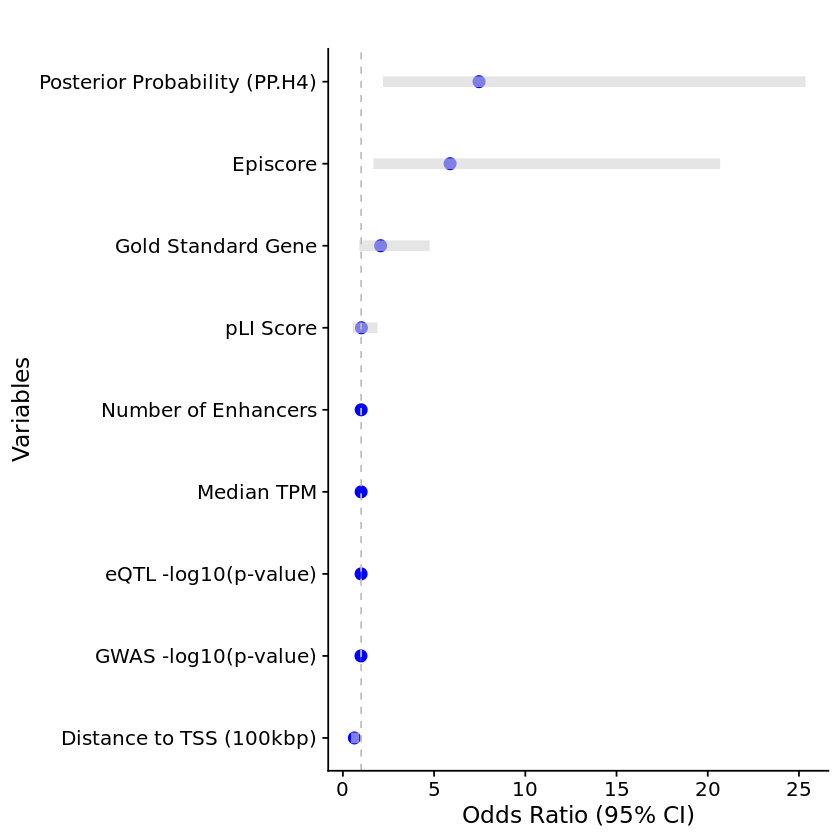

In [57]:
# Creating a data frame for the regression results
regression_results <- data.frame(
  Variable = c("Posterior Probability (PP.H4)", "Episcore", "Distance to TSS (100kbp)", 
               "Gold Standard Gene", "Median TPM", "eQTL -log10(p-value)", 
               "GWAS -log10(p-value)", "pLI Score", "Number of Enhancers"),
  Estimate = c(2.010, 1.771, -0.462, 0.727, -0.00006941, -0.002325, -0.009687, 0.01747, 0.003031),
  StdError = c(0.6242, 0.6419, 0.1801, 0.4246, 0.0002204, 0.009024, 0.008351, 0.3187, 0.003065),
  PValue = c(0.00128, 0.00579, 0.01031, 0.08670, 0.75280, 0.79663, 0.24606, 0.95628, 0.32265)
)

# Compute confidence intervals
regression_results <- regression_results %>%
  mutate(
    OR = exp(Estimate),
    CI_lower = exp(Estimate - 1.96 * StdError),
    CI_upper = exp(Estimate + 1.96 * StdError)
  )
regression_results
# Plot the forest plot

#png("plots/pp.h4_violin_plot.png", width = 8, height = 10, units = "in", res = 300)
ggplot(regression_results, aes(x = reorder(Variable, OR), y = OR)) +
  geom_point(color = "blue",  size=3, color = "blue") +
  geom_errorbar(aes(ymin = CI_lower, ymax = CI_upper), width = 0,  size = 3, color = "light grey", alpha = 0.6) +
  coord_flip() +
  theme_cowplot() +
  scale_x_discrete(expand = expansion(mult = 0.05)) +  # Reduce row spacing
  labs(title = "",
       x = "Variables",
       y = "Odds Ratio (95% CI)") +
  geom_hline(yintercept = 1, linetype = "dashed", color = "grey")

#dev.off()

In [33]:
#######################################
### Forestplot of regression results ##
#######################################
library(forestplot)

# Create data for the plot (excluding the intercept)
estimate <- fit_summary$coefficients[2:length(fit_summary$coefficients[,1]), 1]
se <- fit_summary$coefficients[2:length(fit_summary$coefficients[,1]), 2]

# Calculate the 95% confidence intervals for log odds ratios
lower <- exp(estimate - 1.96 * se)
upper <- exp(estimate + 1.96 * se)
upper <- ifelse(upper > 20, 20, upper)  # Truncate upper bound at 10 for visualization

# Variables and p-values (excluding the intercept)
variables <- c("PP.H4","Haploinsufficency","TSS Distance (100kbp)","Gold standard gene","Median TPM(log)","eQTL P-value", "GWAS P-value", "pLI ≥ 0.9", "N enhancers")
p_values <- fit_summary$coefficients[2:length(fit_summary$coefficients[,1]), 4]
# Calculate odds ratios
odds_ratios <- exp(estimate)

# Combine all data into a data frame for easier sorting
data <- data.frame(
  variables = variables,
  odds_ratios = odds_ratios,
  lower = lower,
  upper = upper,
  p_values = p_values
)

# Sort the data by odds ratios (effect sizes) in descending order
data <- data[order(data$odds_ratios, decreasing = TRUE), ]

# Prepare data for the forest plot
tabletext <- cbind(
  c("Regression variable", data$variables),
  c("OR", round(data$odds_ratios, 2)),
  c("P-value", formatC(data$p_values, format = "e", digits = 1))
)

# Generate the forest plot for Log Odds Ratios (excluding the intercept)
png("plots/foresplot.png", width = 12, height = 8, units = "in", res = 300)
forestplot(
  labeltext = tabletext,
  mean = c(NA, data$odds_ratios),  # 'NA' for the header row
  lower = c(NA, data$lower),       # 'NA' for the header row
  upper = c(NA, data$upper),       # 'NA' for the header row
  zero = 1,                        # Line for null effect (OR = 1)
  xlab = "Log Odds Ratio",
  boxsize = 0.1,                   # Size of the box for the estimates
  lineheight = unit(0.3, "cm"),    # Adjust vertical space between rows
  colgap = unit(4, "mm"),          # Space between columns
  graphwidth = unit(4, "cm"),      # Set the graph width
  xticks = c(0, 5, 10, 15, 20),    # Define x-axis ticks
  lwd.ci = 1,                      # Increase width of the confidence interval lines (whiskers)
  txt_gp = fpTxtGp(cex = 0.4),
  axes = gpar(cex = 2),
  gpar = fpTxtGp(
    label = gpar(fontsize = 10),    # Increase the size of variable labels
    ticks = gpar(fontsize = 12),   # Increase the size of axis ticks
    xlab = gpar(fontsize = 30)     # Increase the size of x-axis label
  ),
  col = fpColors(box = "blue", lines = "blue", zero = "black"), # Set box and whisker colors
  bg = "transparent"                      # Set background color to grey
)
dev.off()

p1 = regression_df %>% 
  mutate(gene_intersect = ifelse(gene_intersect == 1, "eQTL with\ncgene", "eQTL without\ncgene")) %>%
  ggplot(aes(x = gene_intersect, y = mean_PP.H4, fill = gene_intersect)) +
  geom_violin(trim = FALSE, fill = "light grey", color = "black", alpha = 0.5) +  # Violin plot
  geom_boxplot(width = 0.1, color = "black", outlier.shape = NA) +  # Boxplot inside violin plot
  theme_cowplot() +
  ylim(0.5, 1) +
  xlab("") +
  ylab("PP.H4.abf") +
  scale_fill_manual(name = "",
                    values = c("eQTL without\ncgene" = "white", "eQTL with\ncgene" = "#F8766D"),
                    labels = c("eQTL without cgene", "eQTL with cgene")
                   ) +  # Define custom colors
  theme(
    plot.title = element_text(size = 20, face = "plain"),
    axis.title.y = element_text(size = 20, margin = margin(r = 10)),
    axis.text.x = element_text(size = 20),
    axis.text.y = element_text(size = 20),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16)
  )
png("plots/pp.h4_violin_plot.png", width = 8, height = 10, units = "in", res = 300)
p1
dev.off()

ERROR: Error in library(forestplot): there is no package called ‘forestplot’


In [ ]:
####################################
#### CRISPRi regression ############
####################################
regression_df = cres_w_grnas %>%
    filter(significant == 1) %>%
    left_join(blood_tpm, "ensembl_id") %>% 
    left_join(gene_metrics, "ensembl_id") %>%
    mutate(gene_intersect = as.factor(ifelse(target_gene %in% overlapping_target_genes,1,0))) %>%
    mutate(tss_distance_100kbp = abs(tss_distance/100000)) %>%
    mutate(log_median_tpm = log(median_tpm + 1)) %>% # scale pp.h4 so that 0.5 is one unit change
    distinct(target_gene,.keep_all=T) %>%
    mutate(median_tpm = ifelse(is.na(median_tpm), whl_bld_tpm, median_tpm)) %>% # if na make whlbld
    mutate(pLI = as.factor(ifelse(pLI >= 0.9,1,0)), gold_standard = ifelse(ensembl_id %in% rare_genes$rare_genes,1,0))

colnames(regression_df)

# metrics to add, I'm interested in what crispri metrics predict overlap not eqtl metrics
# gwas p-value
# PIP
# Power
#

library(glmnet)
fit = glm(gene_intersect ~ Episcore + logfc + tss_distance_100kbp + as.factor(gold_standard) + median_tpm + pLI + num_enh,
          regression_df, family = "binomial")

fit_summary <- summary(fit)
fit_summary
pvalue = fit_summary$coefficients[2, "Pr(>|z|)"]
OR = exp(fit_summary$coefficients[2,1])

In [ ]:
# Create data for the plot (excluding the intercept)
estimate <- fit_summary$coefficients[2:length(fit_summary$coefficients[,1]), 1]
se <- fit_summary$coefficients[2:length(fit_summary$coefficients[,1]), 2]

# Calculate the 95% confidence intervals for log odds ratios
lower <- exp(estimate - 1.96 * se)
upper <- exp(estimate + 1.96 * se)
upper <- ifelse(upper > 10, 10, upper)  # Truncate upper bound at 10 for visualization

# Variables and p-values (excluding the intercept)
variables <- c("Haploinsufficency","logfc","TSS Distance (100kbp)","Gold standard gene","Median TPM(log)","pLI ≥ 0.9", "N enhancers")
p_values <- fit_summary$coefficients[2:length(fit_summary$coefficients[,1]), 4]
# Calculate odds ratios
odds_ratios <- exp(estimate)

# Combine all data into a data frame for easier sorting
data <- data.frame(
  variables = variables,
  odds_ratios = odds_ratios,
  lower = lower,
  upper = upper,
  p_values = p_values
)

# Sort the data by odds ratios (effect sizes) in descending order
data <- data[order(data$odds_ratios, decreasing = TRUE), ]

# Prepare data for the forest plot
tabletext <- cbind(
  c("Regression variable", data$variables),
  c("OR", round(data$odds_ratios, 2)),
  c("P-value", formatC(data$p_values, format = "e", digits = 1))
)

# Generate the forest plot for Log Odds Ratios (excluding the intercept)
#png("plots/crispri_foresplot.png", width = 24, height = 16, units = "in", res = 300)
forestplot(
  labeltext = tabletext,
  mean = c(NA, data$odds_ratios),  # 'NA' for the header row
  lower = c(NA, data$lower),       # 'NA' for the header row
  upper = c(NA, data$upper),       # 'NA' for the header row
  zero = 1,                        # Line for null effect (OR = 1)
  xlab = "Log Odds Ratio",
  boxsize = 0.1,                   # Size of the box for the estimates
  lineheight = unit(0.3, "cm"),    # Adjust vertical space between rows
  colgap = unit(4, "mm"),          # Space between columns
  graphwidth = unit(4, "cm"),      # Set the graph width
  xticks = c(0, 5, 10),    # Define x-axis ticks
  lwd.ci = 1,                      # Increase width of the confidence interval lines (whiskers)
  txt_gp = fpTxtGp(cex = 0.4),
  axes = gpar(cex = 2),
  gpar = fpTxtGp(
    label = gpar(fontsize = 10),    # Increase the size of variable labels
    ticks = gpar(fontsize = 12),   # Increase the size of axis ticks
    xlab = gpar(fontsize = 30)     # Increase the size of x-axis label
  ),
  col = fpColors(box = "blue", lines = "blue", zero = "black"), # Set box and whisker colors
  bg = "transparent"                      # Set background color to grey
)
#dev.off()

Warning message:
“Removed 16 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 16 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 126 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 126 rows containing missing values or values outside the scale range (`geom_point()`).”


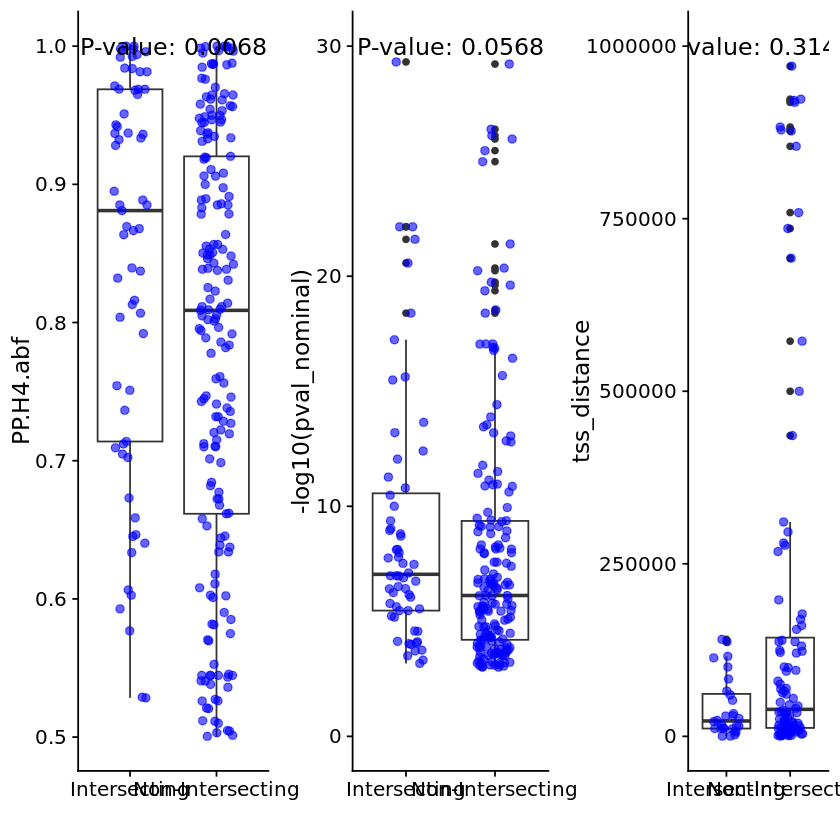

In [44]:
library(gridExtra)

boxplot_df = cres_w_grnas_egene[cres_w_grnas_egene$grna_target %in% overlapping_cres,] %>%
    mutate(gene_intersect = as.factor(ifelse(target_gene %in% overlapping_target_genes,"Intersecting","Non-Intersecting"))) %>% distinct(target_gene,.keep_all=T)

abf_test1 <- wilcox.test(boxplot_df$PP.H4.abf ~ boxplot_df$gene_intersect, exact = FALSE)
abf_test2 <- wilcox.test(boxplot_df$pval_nominal ~ boxplot_df$gene_intersect, exact = FALSE)
abf_test3 <- wilcox.test(boxplot_df$tss_distance ~ boxplot_df$gene_intersect, exact = FALSE)

p1 = ggplot(boxplot_df, aes(x = gene_intersect, y = PP.H4.abf)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, size = 2, alpha = 0.6, color = "blue") +  # Adding individual values as jittered dots
  theme_cowplot() +
  annotate("text", x = 1.5, y = 1, label = paste0("P-value: ", round(abf_test1$p.value, 4)), size = 5, hjust = 0.5) +
  xlab("")

p2 = ggplot(boxplot_df, aes(x = gene_intersect, y = -log10(pval_nominal))) +
  geom_boxplot() +
  geom_jitter(width = 0.2, size = 2, alpha = 0.6, color = "blue") +  # Adding individual values as jittered dots
  theme_cowplot() +
  annotate("text", x = 1.5, y = 30, label = paste0("P-value: ", round(abf_test2$p.value, 4)), size = 5, hjust = 0.5) +
  xlab("") + ylim(0,30)

p3 = ggplot(boxplot_df, aes(x = gene_intersect, y = tss_distance)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, size = 2, alpha = 0.6, color = "blue") +  # Adding individual values as jittered dots
  theme_cowplot() +
  annotate("text", x = 1.5, y = 1000000, label = paste0("P-value: ", round(abf_test3$p.value, 4)), size = 5, hjust = 0.5) +
  xlab("") + ylim(0, 1000000)

#png("plots/pp.h4_pval_distance_boxplots.png", width = 25, height = 8, units = "in", res = 300)
grid.arrange(grobs = list(p1, p2,p3), ncol = 3)
#dev.off()

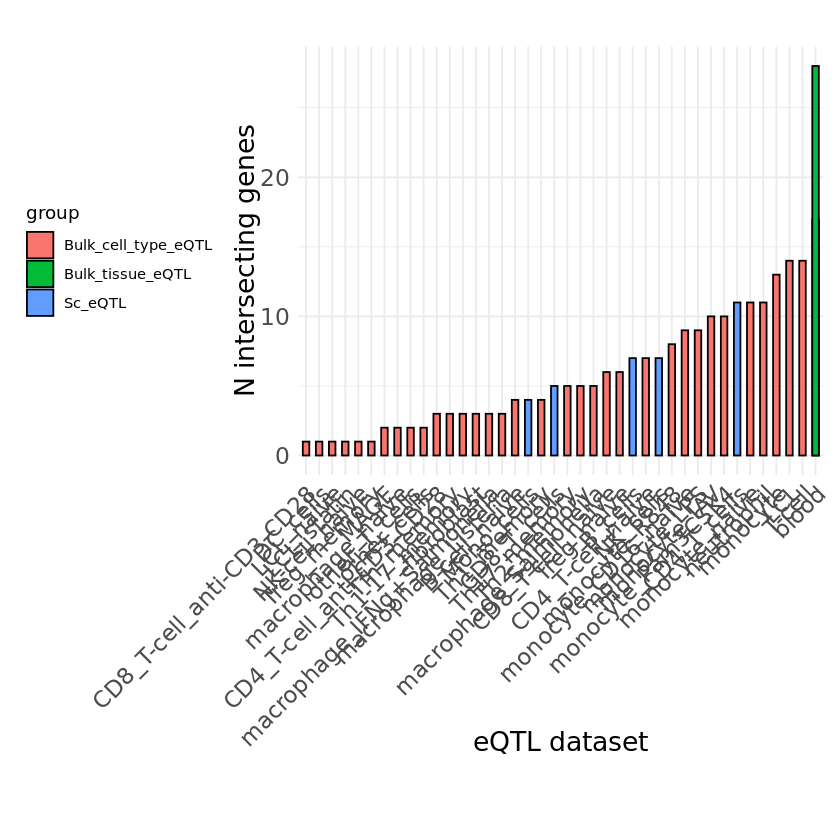

In [45]:
####################################
# What is the overlap by cell type #
####################################
# Define the sc_qtls
sc_qtls <- c("NK_cells", "B_cells", "CD4_T_cells", "CD8_T_cells", "DC_mean", "Mono_cells", "Other_cells", "Other_T_cells")

overlapping_eqtls <- cres_w_grnas_egene %>%
  filter(target_gene %in% overlapping_cres_cgene)

#png("plots/intersections_by_celltype.png", width = 14, height = 10,units = "in", res = 300)

# Create the ggplot with ordered bars and angled x-axis labels
overlapping_eqtls %>%
  mutate(uniq_id = paste(eqtl, ensembl_id, grna_target, sep = "_")) %>% 
  distinct(uniq_id, .keep_all = TRUE) %>%  # Remove multiple GWAS per gene and eQTL
  group_by(eqtl) %>% 
  summarise(N = n()) %>% 
  arrange(N) %>%  # Arrange by N to ensure order
  mutate(eqtl = ifelse(eqtl == "GTEx", "blood", eqtl)) %>%
  mutate(eqtl = factor(eqtl, levels = unique(eqtl)),  # Use unique values for factor levels
         group = ifelse(eqtl %in% c("blood", "GTEx"), "Bulk_tissue_eQTL", 
                        ifelse(eqtl %in% sc_qtls, "Sc_eQTL", "Bulk_cell_type_eQTL"))) %>%
  ggplot( aes(x = eqtl, y = N, fill = group)) +
  geom_bar(stat = "identity", color = "black", width = 0.5, position = position_dodge(width = 0.7)) +
  theme_minimal() +
  labs(title = "", x = "eQTL dataset", y = "N intersecting genes") +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1),  # Rotate the x-axis labels
    axis.text.y = element_text(size = 14),
    legend.position = "left",  # Move the legend to the left side of the plot
    plot.margin = margin(t = 10, r = 10, b = 50, l = 10)  # Increase the bottom margin further
  ) +
  coord_cartesian(clip = "off")
#dev.off()

In [48]:
###################
### Upset plot ####
###################

if (!require(UpSetR)) {
  install.packages("UpSetR")
}
library(UpSetR)
library(dplyr)
library(tidyr)

# Step 1: Data Preparation
venn_df <- overlapping_eqtls %>%
  mutate(eqtl = ifelse(eqtl == "GTEx", "blood", eqtl)) %>%
  mutate(group = ifelse(eqtl %in% c("blood", "GTEx"), "Bulk_tissue_eQTL", 
                        ifelse(eqtl %in% sc_qtls, "Sc_eQTL", "Bulk_cell_type_eQTL")),
         group = factor(group, levels = unique(group))) %>%
  mutate(uniq_id = paste(group, ensembl_id, grna_target, sep = "_")) %>% 
  distinct(uniq_id, .keep_all = TRUE)  # Remove multiple GWAS per gene and eQTL

# Step 2: Create a binary matrix for the UpSet plot
upset_data <- venn_df %>%
  select(target_gene, group) %>%
  distinct() %>%
  mutate(value = 1) %>%  # Mark presence with a value of 1
  spread(key = group, value = value, fill = 0)  # Create a wide format with binary values

# Convert to a matrix format
upset_matrix <- as.data.frame(upset_data)
upset_matrix <- upset_matrix[, -1]  # Remove target_gene column, as we just need binary columns

png(filename = "plots/upset_plot.png", width = 10, height = 8, units = "in", res = 300)
# Step 3: Create the UpSet Plot
upset(upset_matrix, 
      sets = c("Bulk_tissue_eQTL", "Sc_eQTL", "Bulk_cell_type_eQTL"), 
      order.by = "degree", 
      decreasing = FALSE,
      keep.order = FALSE, 
      main.bar.color = "black", 
      sets.bar.color = c("#00BFC4", "#F8766D", "#440154ff"), 
      text.scale = c(2, 2, 2, 2, 2.3, 2))
dev.off()

pdf 
  2

Warning message:
“Removed 6 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_point()`).”


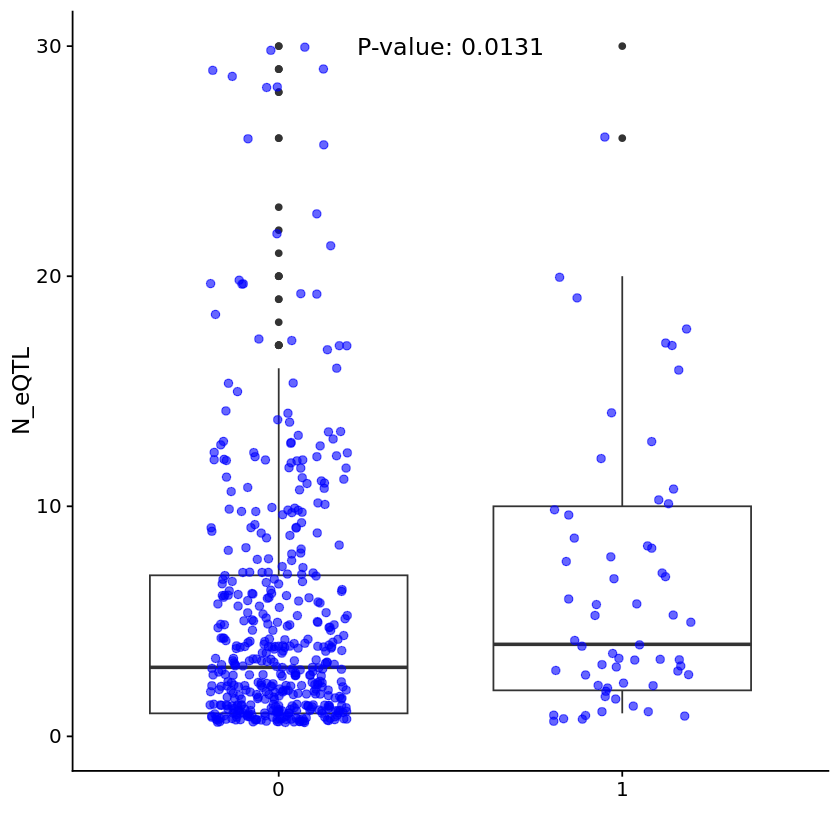

In [49]:
########################################################################
# Are eQTLs that intersect genes replicated in multiple eQTL studies. #
########################################################################

n_eqtl = cres_w_grnas_egene %>%
  mutate(uniq_id = paste(grna_target, eqtl, sep="_")) %>% distinct(uniq_id, .keep_all = T) %>%# only unique grna_eqtl pairs
  group_by(grna_target) %>% summarise(N_eQTL = n()) %>% 
  mutate(gene_intersect = as.factor(ifelse(grna_target %in% overlapping_eqtls$grna_target,1,0)))

abf_test1 <- wilcox.test(n_eqtl$N_eQTL ~ n_eqtl$gene_intersect, exact = FALSE)

ggplot(n_eqtl, aes(x = gene_intersect, y = N_eQTL)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, size = 2, alpha = 0.6, color = "blue") +  # Adding individual values as jittered dots
  theme_cowplot() +
  annotate("text", x = 1.5, y = 30, label = paste0("P-value: ", round(abf_test1$p.value, 4)), size = 5, hjust = 0.5) +
  xlab("") + ylim(0,30)

[1] "B"
[1] "CD4_T"
[1] "CD8_T"
[1] "DC"
[1] "Mono"
[1] "NK"


Warning message:
“Removed 37 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 37 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 37 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 31 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 37 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 37 rows containing missing values (`geom_point()`).”


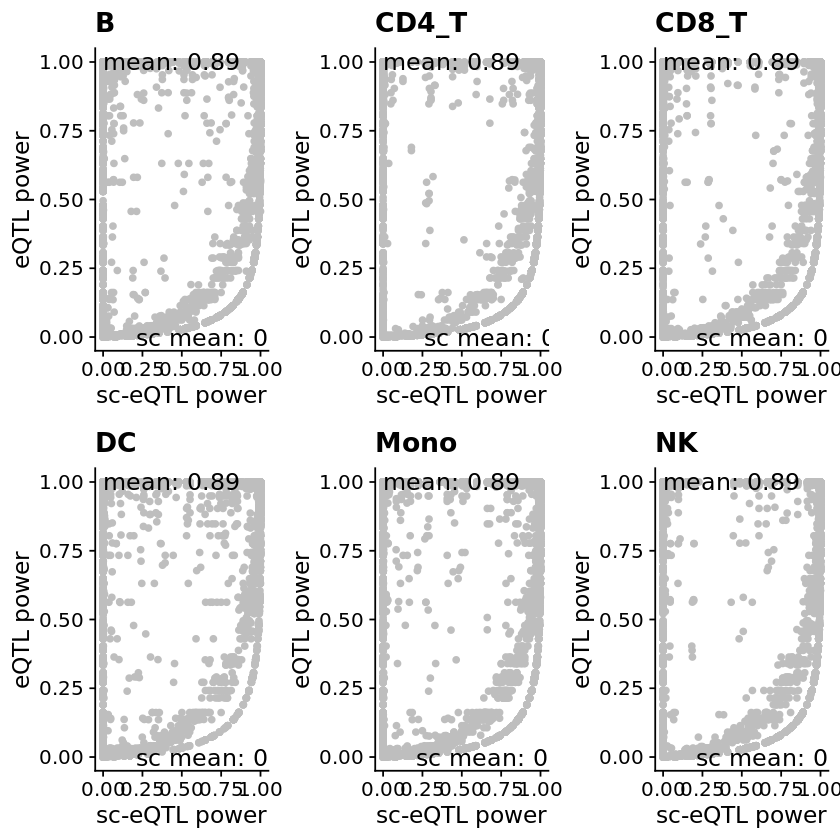

In [5]:
###############################################
### Compare Power between sc and bulk #########
###############################################
# Load GRC 38 genes positions
annot_file = "data/gencode.v33.annotation.gtf.gz"
annot <- read.table(annot_file, header = F, sep = "\t", stringsAsFactors = F)
## Keep only genes from chr1-22
annot <- annot[annot$V1 %in% c(paste0("chr", 1:22)), ]
annot <- annot[annot$V3 %in% "gene", ]
annot$ensembl_id <- sapply(annot$V9, function(x) {
  unlist(strsplit(sub("gene_id ", "", unlist(strsplit(x, ";"))[1]), "[.]"))[1]
})
annot$gene_name <- sapply(annot$V9, function(x) {
  unlist(strsplit(sub(".*gene_name ", "", unlist(strsplit(x, ";"))[3]), "[.]"))[1]
})

gtex_gene_distances = fread("eQTL_gene_distances/GTEx_gene_distance.txt") %>%
  mutate(coord = grna_target,
         ensembl_id = str_split_fixed(phenotype_id, "\\.",2)[,1],
         unique_id = paste0(coord,ensembl_id))
# Load eQTL power
gtex.power <- fread("power_results/GTEx.power.results.txt") %>%
  rename(ensembl_id = genes) %>%
  filter(ensembl_id %in% gtex_gene_distances$ensembl_id) %>%
  left_join(annot[,c("ensembl_id","gene_name")], "ensembl_id") %>%
  mutate(snp_gene = paste0(snp, ":", gene_name))

plot_list <- list()  # Create an empty list to store plots

cell.name <- c("B", "CD4_T", "CD8_T", "DC", "Mono", "NK")

for (i in seq_along(cell.name)) {  # Use seq_along to create an index
  name <- cell.name[i]  # Access the current cell type name
  
  print(name)
  
  # Load sc-eQTL power
  sceqtl.power <- fread(paste0("power_results/", name, ".power.results.txt")) %>%
    mutate(snp_gene = paste0(snp, ":", genes)) %>%
    filter(genes %in% gtex_gene_distances$gene_name)
  
  # Join dataframes
  eqtl.power <- sceqtl.power %>% left_join(gtex.power, by = "snp_gene")
  sc.mean <- mean(eqtl.power$overall_power, na.rm = TRUE)
  bulk.mean <- mean(eqtl.power$eQTL.power.y, na.rm = TRUE)
  
  # Create the plot
  plot <- ggplot(eqtl.power, aes(x = overall_power, y = eQTL.power.y)) +
    geom_point(color = "grey") +
    theme_cowplot() +
    labs(title = name, x = "sc-eQTL power", y = "eQTL power") +
    annotate("text", x = 0.25, y = 1, label = paste0("bulk mean: ", round(bulk.mean, 2)), size = 5, hjust = 0.5) +
    annotate("text", x = 0.75, y = 0, label = paste0("sc mean: ", round(sc.mean, 2)), size = 5, hjust = 0.5)
  
  # Store the plot in the plot list
  plot_list[[i]] <- plot  # Use the index i to store plots
}

#png("plots/power_scatter_plots.png", width = 15, height = 10,units = "in", res = 300)
# Use grid.arrange to print all plots together
do.call(grid.arrange, c(plot_list, nrow = 2))
#dev.off()

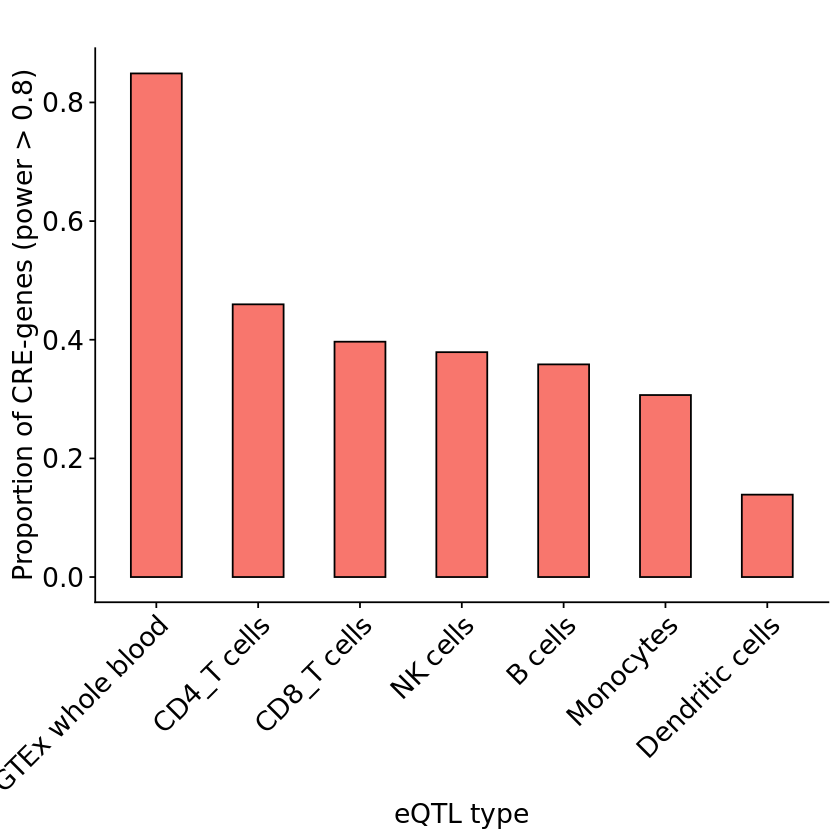

In [6]:
gtex.power <- fread("power_results/GTEx.power.results.txt") %>%
  rename(ensembl_id = genes) %>%
  filter(ensembl_id %in% gtex_gene_distances$ensembl_id) %>%
  left_join(annot[,c("ensembl_id","gene_name")], "ensembl_id") %>%
  mutate(snp_gene = paste0(snp, ":", gene_name)) %>%
  distinct(snp_gene, .keep_all = T)

# Load sc-eQTL power
sceqtl.power <- fread(paste0("power_results/CD4_T.power.results.txt")) %>%
  mutate(snp_gene = paste0(snp, ":", genes)) %>%
  distinct(snp_gene, .keep_all = T) %>%
  dplyr::select(snp_gene, overall_power)

# Join dataframes
eqtl.power <- gtex.power %>% left_join(sceqtl.power, by = "snp_gene") %>% 
  dplyr::select(snp, snp_gene, eQTL.power, overall_power)
colnames(eqtl.power) = c("snp","snp_gene","GTEx_power", "CD4T_power")

cell.name <- c("B","CD8_T", "DC", "Mono", "NK")

for (name in cell.name){
  
  # Load sc-eQTL power
  sceqtl.power <- fread(paste0("power_results/",name,".power.results.txt")) %>%
    mutate(snp_gene = paste0(snp, ":", genes)) %>%
    distinct(snp_gene, .keep_all = T) %>%
    dplyr::select(snp_gene, overall_power)
  
  eqtl.power <- eqtl.power %>% left_join(sceqtl.power, by = "snp_gene")
  
}

eqtl.power[is.na(eqtl.power)] = 0

plot_df = data.frame(eQTL = c("GTEx whole blood","CD4_T cells", "B cells", "CD8_T cells", "Dendritic cells", "Monocytes", "NK cells"),
                     Proportion = apply(eqtl.power[, 3:9], 2, function(x) sum(x > 0.79, na.rm = TRUE) / nrow(eqtl.power)))

# Order the data frame by Proportion
plot_df <- plot_df %>%
  arrange(desc(Proportion)) %>%
  mutate(eQTL = factor(eQTL, levels = eQTL)) # Reorder factor levels


#png("plots/prop_cres_power_80.png", width = 7, height = 6,units = "in", res = 300)
# Create the plot
ggplot(plot_df, aes(x = eQTL, y = Proportion)) +
  geom_bar(stat = "identity", color = "black", fill = "#F8766D", width = 0.5, position = position_dodge(width = 0.7)) +
  labs(title = "", x = "eQTL type", y = "Proportion of CRE-genes (power > 0.8)") +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 16, angle = 45, hjust = 1), # Rotate x-axis text
    axis.text.y = element_text(size = 16)
  )

#dev.off()

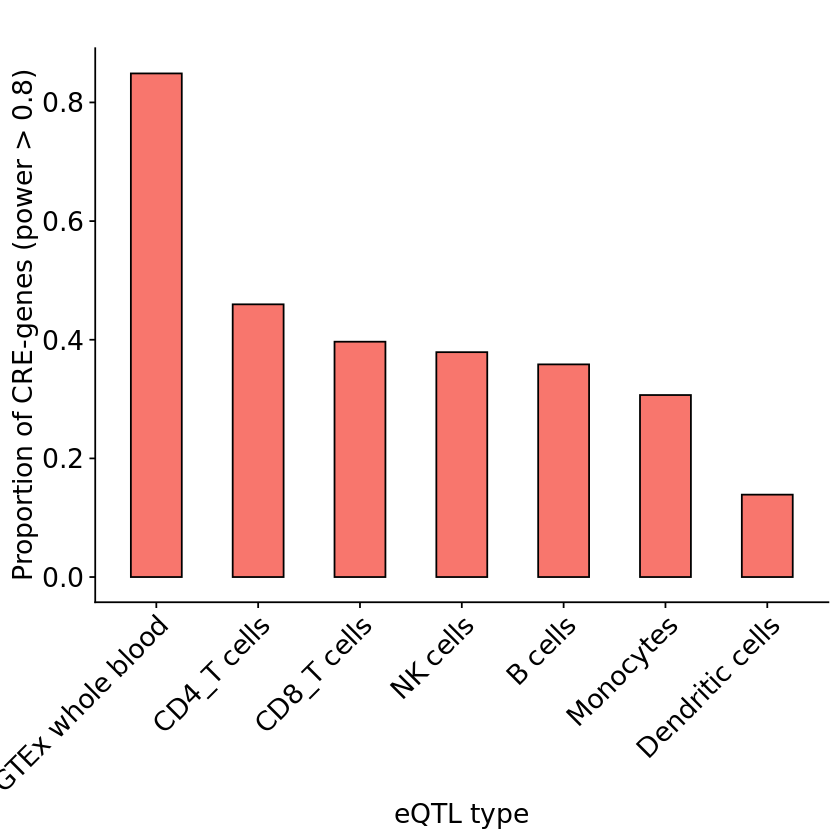

In [6]:
gtex.power <- fread("power_results/GTEx.power.results.txt") %>%
  rename(ensembl_id = genes) %>%
  filter(ensembl_id %in% gtex_gene_distances$ensembl_id) %>%
  left_join(annot[,c("ensembl_id","gene_name")], "ensembl_id") %>%
  mutate(snp_gene = paste0(snp, ":", gene_name)) %>%
  distinct(snp_gene, .keep_all = T)

# Load sc-eQTL power
sceqtl.power <- fread(paste0("power_results/CD4_T.power.results.txt")) %>%
  mutate(snp_gene = paste0(snp, ":", genes)) %>%
  distinct(snp_gene, .keep_all = T) %>%
  dplyr::select(snp_gene, overall_power)

# Join dataframes
eqtl.power <- gtex.power %>% left_join(sceqtl.power, by = "snp_gene") %>% 
  dplyr::select(snp, snp_gene, eQTL.power, overall_power)
colnames(eqtl.power) = c("snp","snp_gene","GTEx_power", "CD4T_power")

cell.name <- c("B","CD8_T", "DC", "Mono", "NK")

for (name in cell.name){
  
  # Load sc-eQTL power
  sceqtl.power <- fread(paste0("power_results/",name,".power.results.txt")) %>%
    mutate(snp_gene = paste0(snp, ":", genes)) %>%
    distinct(snp_gene, .keep_all = T) %>%
    dplyr::select(snp_gene, overall_power)
  
  eqtl.power <- eqtl.power %>% left_join(sceqtl.power, by = "snp_gene")
  
}

eqtl.power[is.na(eqtl.power)] = 0

plot_df = data.frame(eQTL = c("GTEx whole blood","CD4_T cells", "B cells", "CD8_T cells", "Dendritic cells", "Monocytes", "NK cells"),
                     Proportion = apply(eqtl.power[, 3:9], 2, function(x) sum(x > 0.79, na.rm = TRUE) / nrow(eqtl.power)))

# Order the data frame by Proportion
plot_df <- plot_df %>%
  arrange(desc(Proportion)) %>%
  mutate(eQTL = factor(eQTL, levels = eQTL)) # Reorder factor levels


#png("plots/prop_cres_power_80.png", width = 7, height = 6,units = "in", res = 300)
# Create the plot
ggplot(plot_df, aes(x = eQTL, y = Proportion)) +
  geom_bar(stat = "identity", color = "black", fill = "#F8766D", width = 0.5, position = position_dodge(width = 0.7)) +
  labs(title = "", x = "eQTL type", y = "Proportion of CRE-genes (power > 0.8)") +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 16, angle = 45, hjust = 1), # Rotate x-axis text
    axis.text.y = element_text(size = 16)
  )

#dev.off()

In [7]:
plot_df

,eQTL,Proportion
,<fct>,<dbl>
GTEx_power,GTEx whole blood,0.8489202
CD4T_power,CD4_T cells,0.4597011
overall_power.y,CD8_T cells,0.3966999
overall_power,NK cells,0.3790650
overall_power.x,B cells,0.3584684
overall_power.y.y,Monocytes,0.3067944
overall_power.x.x,Dendritic cells,0.1388873


In [20]:
#################################################
### Make boxplot of MAFs of intersecting snps ###
#################################################
# Load targeted GWAS variants
cres_w_grnas = fread("cres_with_grnas.txt")
# flip alleles to match gwas snp ids
temp = gsub("_", ":", cres_w_grnas$finemap_snp_intersect_grna)
temp = str_split_fixed(temp,":",4)[,2]
cres_w_grnas$snp_pos = paste0(cres_w_grnas$chr, ":", temp)
# Load sumstats to obtain MAFs
# Load GWAS summary stats
sumstats = fread("/gpfs/commons/groups/lappalainen_lab/sghatan/stingseq_eqtl_overlap/data/UKBB_sumstats/30000_formatted.tsv")
sumstats$snp_pos = paste0(sumstats$Chr,":",sumstats$Pos)
sumstats_filtered = sumstats %>% filter(snp_pos %in% cres_w_grnas$snp_pos)

cres_w_grnas_egene = fread("cres_with_grna_eqtls.txt")

grna_cres_w_cgenes = unique(cres_w_grnas$grna_target[cres_w_grnas$significant == 1])
grna_cres_w_egenes = unique(cres_w_grnas_egene$grna_target)
overlapping_cres = grna_cres_w_cgenes[grna_cres_w_cgenes %in% grna_cres_w_egenes]

In [21]:
plot_df = cres_w_grnas %>%
  filter(grna_target %in% c(grna_cres_w_cgenes, grna_cres_w_egenes) & !grna_target %in% overlapping_cres) %>%
  distinct(grna_target, .keep_all=T) %>%
  mutate(unique_CREs = ifelse(grna_target %in% grna_cres_w_cgenes, "cgene","egene")) %>%
  left_join(sumstats_filtered[,c("snp_pos","minor_AF")], "snp_pos")

test = wilcox.test(plot_df$minor_AF[plot_df$unique_CREs == "cgene"], plot_df$minor_AF[plot_df$unique_CREs == "egene"])
print(test)

png("plots/boxplot_maf.png", width = 6, height = 6,units = "in", res = 300)
ggplot(plot_df, aes(x = unique_CREs, y = minor_AF, fill = unique_CREs)) +
  geom_violin(trim = FALSE, fill = "light grey", color = "black", alpha = 0.5) +  # Violin plot
  geom_boxplot(width = 0.1, color = "black", outlier.shape = NA) +  # Boxplot inside violin plot
  theme_cowplot() +
  ylim(0,0.5) +
  annotate("text", x = 1.5, y = 0.75, label = paste0("p-value: ", round(test$p.value, 3)), size = 5, hjust = 0.5) +
  labs(title = "", x = "", y = "MAF", fill = "CRE-gene pairs") +
  theme(
      plot.title = element_text(size = 20, face = "plain"),
      axis.title.y = element_text(size = 20),
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20),
      legend.text = element_text(size = 16),
      legend.title = element_text(size = 16)
  )
dev.off()


	Wilcoxon rank sum test with continuity correction

data:  plot_df$minor_AF[plot_df$unique_CREs == "cgene"] and plot_df$minor_AF[plot_df$unique_CREs == "egene"]
W = 7721, p-value = 0.009501
alternative hypothesis: true location shift is not equal to 0



Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 358 rows containing missing values or values outside the scale range (`geom_violin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2


	Wilcoxon rank sum test with continuity correction

data:  crispr.power$power[crispr.power$unique_CREs == "cgene"] and crispr.power$power[crispr.power$unique_CREs == "egene"]
W = 26724, p-value = 7.401e-10
alternative hypothesis: true location shift is not equal to 0



Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_boxplot()`).”


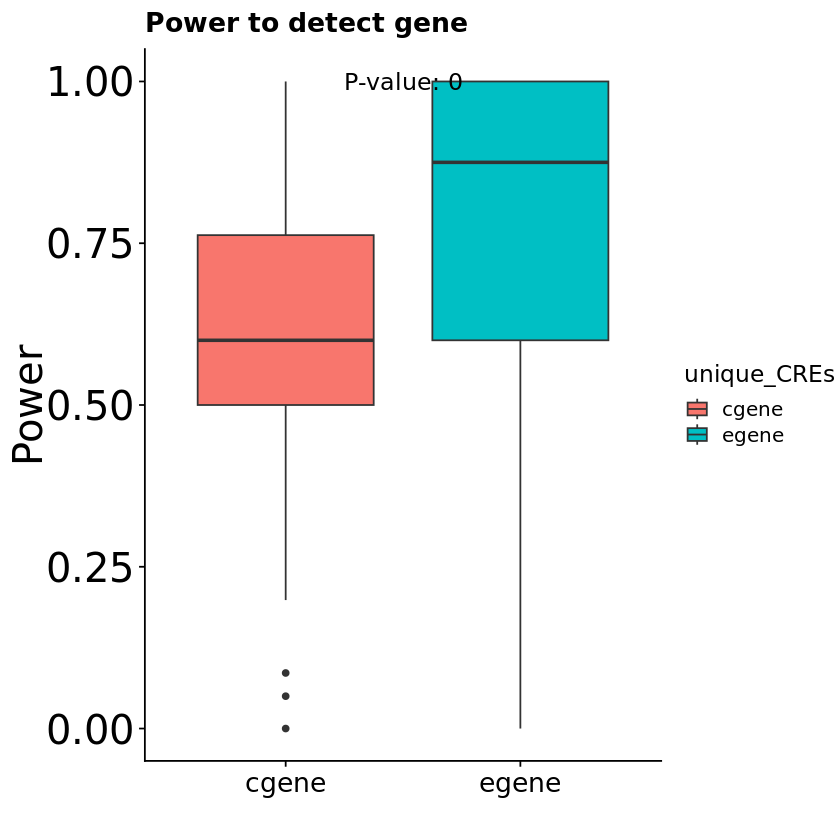

In [22]:
crispr.power = fread("cres_with_grnas_power.txt") %>%
  filter(target_gene %in% c(cres_w_grnas$target_gene[cres_w_grnas$significant == 1], cres_w_grnas_egene$target_gene)) %>%
  mutate(both = ifelse(target_gene %in% cres_w_grnas_egene$target_gene & target_gene %in% cres_w_grnas$target_gene[cres_w_grnas$significant == 1], 1,0)) %>%
  filter(both == 0) %>%
  mutate(unique_CREs = ifelse(target_gene %in% cres_w_grnas_egene$target_gene, "egene", "cgene"))

test = wilcox.test(crispr.power$power[crispr.power$unique_CREs == "cgene"], crispr.power$power[crispr.power$unique_CREs == "egene"])
print(test)

ggplot(crispr.power, aes(x = unique_CREs, y = power, fill = unique_CREs)) +
  geom_boxplot() +
  theme_cowplot() +
  annotate("text", x = 1.5, y = 1, label = paste0("P-value: ", round(test$p.value, 2)), size = 5, hjust = 0.5) +
  labs(title = "Power to detect gene", x = "", y = "Power") +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 24),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 24)
  )

In [20]:
sum(crispr.power$unique_CREs == "cgene")

[1] 113

In [ ]:
crispr.power

In [23]:
sorted.eqtl.power <- eqtl.power %>%
  arrange(desc(DC_power), desc(Mono_power), desc(B_power), 
          desc(NK_power), desc(CD8_T_power), desc(CD4T_power), desc(GTEx_power)) %>%
  mutate(ensembl_id = str_split_fixed(snp_gene, ":", 3)[, 3]) %>%
  distinct(ensembl_id, .keep_all = TRUE)

plot_df2 = plot_df %>% left_join(sorted.eqtl.power, "ensembl_id")

sum(is.na(plot_df2$snp))
nrow(plot_df2)

test = wilcox.test(plot_df2$GTEx_power[plot_df2$unique_CREs == "cGene"], plot_df2$GTEx_power[plot_df2$unique_CREs == "eGene"])
print(test)

#png("plots/boxplot_maf.png", width = 6, height = 6,units = "in", res = 300)
ggplot(plot_df2, aes(x = unique_CREs, y = GTEx_power, fill = unique_CREs)) +
    geom_boxplot() +
  geom_jitter(width = 0.2, size = 2, alpha = 0.6, color = "blue") +  # Adding individual values as jittered dots
  theme_cowplot() +
  annotate("text", x = 1.5, y = 0.55, label = paste0("P-value: ", round(test$p.value, 3)), size = 5, hjust = 0.5) +
  labs(title = "MAFs of uniquely mapped CREs", x = "", y = "MAF")
#dev.off()

ERROR: [1m[33mError[39m in `arrange()`:[22m
[1m[22m[36mℹ[39m In argument: `..1 = DC_power`.
[1mCaused by error:[22m
[33m![39m object 'DC_power' not found
